# General lib imports

In [1]:
import pandas as pd
import numpy as np
from progressbar.bar import ProgressBar

# Code

## Functions

### compute_activation

In [2]:
def compute_activation (X, activation_type):
    '''Defining activation functions
     Takes a nparray or a single value
    # Returns in the same format
    
    For softmax : assuming that X.shape[0]== n_neurons,
        the axis0 of array X is used for computing the mean 
    '''
    X=np.array(X)
    if activation_type == 'relu':
        return np.maximum(X,0)
    elif activation_type == 'sigmoid':
        return 1/(1+np.exp(-X))
    elif activation_type == 'tanh':
        return np.tanh(X)
    elif activation_type == 'linear':
        return X
    elif activation_type == 'softmax':
        exp_x = np.exp(X)
        return exp_x / exp_x.sum(axis=0)

    #raise error if unknown type
    else:
        raise ValueError(f'Unknown activation type {activation_type}. \
Supported types : linear, relu, sigmoid, tanh, softmax')

### compute_activation (version with derivatives option, not used in backprop, kept here in cas of future need)

In [3]:
def compute_activation_old (X, activation_type, derivative=False):
    '''Defining activation functions
     Takes a nparray or a single value
    # Returns in the same format
    
    For softmax : assuming that X.shape[0]== n_neurons,
        the axis0 of array X is used for computing the mean 
    '''
    X=np.array(X)
    if activation_type == 'relu':
        if derivative == False:
            return np.maximum(X,0)
        else:
            return (X > 0).astype(int)
        
    elif activation_type == 'sigmoid':
        if derivative == False:
            return 1 / (1 + np.exp(-X))
        else:
            return np.exp(-X) / np.square(1 + np.exp(-X))
    
    elif activation_type == 'tanh':
        if derivative == False:
            return np.tanh(X)
        else:
            return np.square(1 / np.cosh(X))
            
    elif activation_type == 'linear':
        if derivative == False:
            return X
        else:
            return np.ones(X.shape)
            
    elif activation_type == 'softmax':
        exp_x = np.exp(X)
        sigma_exp_x = exp_x.sum(axis=0)
        if derivative == False: 
            return exp_x / sigma_exp_x
        else:
            return (exp_x * sigma_exp_x - np.square(exp_x)) / np.square(sigma_exp_x)
        
    #raise error if unknown type
    else:
        raise ValueError(f'Unknown activation type {activation_type}. \
Supported types : linear, relu, sigmoid, tanh, softmax')

### compute_activation_derivative

In [4]:
def compute_activation_derivative (layer_output, activation_type):
    '''Computes the derivative of the activation functions,
       depending of the outputs of the output of these functions
           nota : if occures that for each of the 5 basic activations,
           f'(X) can be expressed simply as a function of f(X)
           
           Takes a nparray or a single value
        # Returns in the same format
           '''
    X_output=np.array(layer_output)
    if activation_type == 'relu':
        return (X_output > 0).astype(int)
    if activation_type == 'linear':
        return np.ones(X_output.shape)
    if activation_type == 'sigmoid':
        return X_output - np.square(X_output)
    if activation_type == 'tanh':
        return 1 - np.square(X_output)
    if activation_type == 'softmax':
        return X_output - np.square(X_output)
    
    #raise error if unknown type
    else:
        raise ValueError(f'Unknown activation type {activation_type}. \
Supported types : linear, relu, sigmoid, tanh, softmax')

### compute_metric

In [5]:
def compute_metric (y, y_pred, metric, loss_derivative=False):
    '''Defining loss and metric functions
     Takes nparrays, lists or a single values
     
     ## IF loss_derivative==False:
         output: always scalar
         
     ## IF loss_derivative==True: (True will be ignored for non-loss metrics)
         Computes the partial derivative of the loss function
           with respect to each component of each sample
         output: 2Darray
            n_samples * 1 for binary_crossentropy or single output regression
            n_samples * n_class for categorical_crossentropy
            n_samples * n_features for multifeatures regression)
    '''
        
    #converting DataFrames, lists or lists of lists to nparray
    y = np.array(y)
    y_pred = np.array(y_pred)
        
    #deal with 1D inputs to forge a n_samples * 1 2D-array
    if len(y.shape) == 1:
        y = np.expand_dims(y, axis = 1)
    if len(y_pred.shape) == 1:
        y_pred = np.expand_dims(y_pred, axis = 1)
            
    #raise errors for unconsistant inputs
    if len(y.shape) > 2:
        raise ValueError('y vector dimension too high. Must be 2 max')
    if len(y_pred.shape) > 2:
        raise ValueError('y_pred vector dimension too high. Must be 2 max')
    if y.shape != y_pred.shape:
        raise ValueError(f'unconsistent vectors dimensions during scoring: \
y.shape= {y.shape} and y_pred.shape= {y_pred.shape}')
        
    #compute loss funtions (or derivatives if loss_derivative==True)
    if metric == 'mse':
        if loss_derivative == False:
            return np.square(y-y_pred).mean()
        else:
            return 1 / y.size * 2 * (y_pred - y)
        
    elif metric == 'mae':
        if loss_derivative == False:
            return np.abs(y-y_pred).mean()
        else:
            return 1 / y.size * (y_pred - y) / np.abs(y - y_pred)
        
    elif metric == 'categorical_crossentropy':
        if loss_derivative == False:
            return -1 / y.shape[0] * ((y * np.log(y_pred)).sum())
        else:
            return -1 / y.shape[0] * (y / y_pred)
        
    elif metric == 'binary_crossentropy':
        if y.shape[1]>1:
            raise ValueError('y vector dimension too high. \
Must be 1 max for binary_crossentropy')
        if loss_derivative == False:
            return -(y*np.log(y_pred)+(1-y)*np.log(1-y_pred)).mean()
        else:
            return -1 / y.size * (y / y_pred - (1-y) / (1-y_pred))
        
    # compute other metrics functions
    ## TODO ## accuracy, f1-score, recall, etc..
    else:
        raise ValueError(f'Unknown metric {metric}. Supported types: \
mse, mae, categorical_crossentropy, binary_crossentropy')

## Optimizers

In [63]:
class adam_optimizer():
    def __init__(self, weights, bias, alpha_init=0.001, beta_1=0.9,
             beta_2=0.999, epsilon=1e-8):
        
        self.alpha_init=alpha_init
        self.beta_1=beta_1
        self.beta_2=beta_2
        self.epsilon=epsilon
    
        self.t=0
        #initializing first and second momentum
        self.m_weights = [np.zeros_like(w) for w in weights]
        self.m_bias = [np.zeros_like(b) for b in bias]
        self.v_weights = self.m_weights.copy()
        self.v_bias = self.m_bias.copy()
        
    def get_update(self, gradient_weights, gradient_bias):
        self.t+=1
        alpha=self.alpha_init*np.sqrt(1-self.beta_2**self.t)/(1-self.beta_1**self.t)
                    
        # updating 1st and 2nd momenta
        self.m_weights=[self.beta_1 * m + (1-self.beta_1) * grad\
                   for m, grad in zip(self.m_weights, gradient_weights)]
        self.m_bias=[self.beta_1 * m + (1-self.beta_1) * grad\
                   for m, grad in zip(self.m_bias, gradient_bias)]
        self.v_weights=[self.beta_2 * v + (1-self.beta_2) * grad**2\
                   for v, grad in zip(self.v_weights, gradient_weights)]
        self.v_bias=[self.beta_2 * v + (1-self.beta_2) * grad**2\
                   for v, grad in zip(self.v_bias, gradient_bias)]
        
        #computing the updates
        weights_update = [- alpha * m / (np.sqrt(v) + self.epsilon)\
                                  for m, v in zip( self.m_weights, self.v_weights)]
        bias_update = [- alpha * m / (np.sqrt(v) + self.epsilon)\
                                  for m, v in zip( self.m_bias, self.v_bias)]
        
        return weights_update, bias_update

## Model class

In [64]:
class handmade_nn ():
    '''
    hand-made version of neural network
    so far, the possibilities are :
    
        - layers activation functions :
            'linear', 'relu', 'sigmoid', 'tanh', 'softmax'
        
        - weights initializers : 'ones', 'glorot_uniform'
        - bias initializers : 'zeros', 'ones'
    
        - loss functions :
            'mse', 'mae', 'binary_crossentropy', 'categorical_crossentropy'
    
        - solver :
            SGD without momentum
    '''
    def __init__ (self, input_dim=0):
        self.weights=[]
        self.bias=[]
        self.activation_types=[]
        self.input_dim=input_dim
        self.n_layers=0
        
        #the followings will be used only if optimizer = adam
        t=0
        ms=[]
        vs=[]
        

    def set_input_dim (self, input_dim):
        self.input_dim = input_dim
        
    def set_loss (self, loss):
        self.loss = loss
        
    def add_dense_layer (self, n_neurons, activation_type, 
                         weights_initializer='glorot_uniform', bias_initializer='zeros'):
        #check if the input_dim is set
        if self.input_dim == 0:
            raise ValueError('input_dim = 0 .\
Use set_input_dim before creating first layer')
            
        #get the size of the input os this layer
        if len(self.bias) == 0:
            previous_dim=self.input_dim
        else:
            previous_dim=(self.bias[-1].shape[0])
            
        #initialize the layer parameters
        if weights_initializer == 'ones':
            self.weights.append(np.ones((n_neurons, previous_dim)))
        elif weights_initializer == 'glorot_uniform':
            limit = np.square(6 / (n_neurons + previous_dim))
            self.weights.append(np.random.uniform(-limit, limit, size = (n_neurons, previous_dim)))
        else:
            raise ValueError(f'Unknown weights initializer {weights_initializer}.\
Supported types : ones, glorot_uniform')
            
        if bias_initializer == 'zeros':
            self.bias.append(np.zeros(n_neurons))
        elif bias_initializer == 'ones':
            self.bias.append(np.ones(n_neurons))
        else:
            raise ValueError(f'Unknown bias initializer {bias_initializer}.\
Supported types : zeros, ones')
            
        self.activation_types.append(activation_type)
        self.n_layers += 1
        
        #test the activation type
        compute_activation(0, activation_type)
        
    def predict (self, X, keep_hidden_layers=False):
        '''input X : list, list of lists, np array, pd DataFrame
               axis 0 = samples
               axis 1 = features
               
           ## IF keep_hidden_layers==False:
           output = y_pred: 2D np-array
               axis 0 = samples
               axis 1 = output features, depending of the size of last layer
               
           ## IF keep_hidden_layers==True:
           outputs = layers_outputs, layers_activation_derivatives
           -output1 = layers_outputs:
               list of 2D np-arrays of outputs of each layer
               len(list)=n_layers+1: 1st element = X itself
                                     last element = y_pred
               axis 0 = samples
               axis 1 = number of neurons of the layer
           -output2 = layers_activation_derivatives:
               list of 2D np-arrays of d_act/d_input of each layer
               len(list)=n_layers
               axis 0 = samples
               axis 1 = number of neurons of the layer
           '''
        #converting DataFrames, lists or lists of lists to nparray
        X = np.array(X)
        
        #deal with 1D inputs to forge a 1 * n_features 2D-array
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis = 0)
            
        #raise errors for unconsistant inputs
        if len(X.shape) > 2:
            raise ValueError('X vector dimension too high. Must be 2 max')
        if X.shape[1] != self.input_dim:
            raise ValueError(f'Unconsistent number of features. \
The network input_dim is {self.input_dim}')
            
        #compute the prediction
        layers_outputs = [X]
        layers_activation_derivatives = []
        for layer_index, activation_type in enumerate(self.activation_types):
            activation_input = np.dot(self.weights[layer_index], X.T)\
                               + np.expand_dims(self.bias[layer_index], axis=1)
            X = compute_activation(activation_input, activation_type).T

            layers_outputs.append(X)
            layers_activation_derivatives.append(\
                compute_activation_derivative(X, activation_type))
                
        if keep_hidden_layers == True:
            return layers_outputs, layers_activation_derivatives
        else:
            return X
    
    def score (self, X, y, metric):
        '''use predict method, then compute_metric function'''
        y_pred=self.predict(X)
        return compute_metric(y, y_pred, metric)
    
    def compute_backpropagation (self, X, y):
        '''This method :
            - executes self.predict(X) WITH keep_hidden_layers
                to keep all intermediate outputs
            - executes compute_metric (y, y_pred, loss) WITH loss_derivative
            - for each layer from last to first : computes loss
              derivatives (aka gradient) with respect to bias and weights
              
            output 1 : gradient with respect to weights 
               (list of 2D arrays 
               len(list) = n_layers
               axis 0 = number of neurons of the layer
               axis 1 = number of neurons of the previous layer (or features in the input)
            output 2 : gradient with respect to bias
               (list of 1D arrays)
               len(list) = n_layers
               axis 0 = number of neurons of the layer
            '''
        delta_weights=[]
        delta_bias=[]
        
        # compute the outputs and the derivatives of each layer
        layers_outputs, layers_activation_derivatives\
                = self.predict(X, keep_hidden_layers = True)
        # compute d_loss/d_ypred
        dloss_doutput = compute_metric (y, 
                                        layers_outputs[-1], 
                                        self.loss, 
                                        loss_derivative = True)
        for layer_index in range(self.n_layers-1, -1, -1):
            # compute d_loss/d_input of the layer
            dloss_dinput = dloss_doutput * layers_activation_derivatives[layer_index]
            
            # compute gradient with respect to weights and bias
            delta_weights.append(np.dot(dloss_dinput.T, layers_outputs[layer_index]))
            delta_bias.append(np.sum(dloss_dinput, axis=0))
            
            # update dloss_doutput for next propagation
            if layer_index > 0:
                dloss_doutput = np.dot (dloss_dinput, self.weights[layer_index])
        
        delta_weights.reverse()
        delta_bias.reverse()
                
        return delta_weights, delta_bias
            
    
    def fit (self, X, y, loss=None, learning_rate=0.01,
             batch_size=1, n_epochs=10, verbose=1,
             optimizer_type='sgd',
             alpha_init=0.001, beta_1=0.9,
             beta_2=0.999, epsilon=1e-8):
        '''input X : 2D array or pd DataFrame
                axis 0 = samples
                axis 1 = features
        '''
        if loss:
            self.loss=loss
        
        if optimizer_type == 'adam':
            optimizer = adam_optimizer (self.weights, self.bias, 
                                        alpha_init=alpha_init, beta_1=beta_1,
                                        beta_2=beta_2, epsilon=epsilon)
        
        X = np.array(X)
        y = np.array(y)
        n_samples = X.shape[0]
        n_minibatches_per_epoch = int(n_samples / batch_size)
        
        if verbose>0:
            print(f'initial loss: {self.score(X, y, self.loss)}')
        
        for epoch_index in range (n_epochs):
            if verbose>1:
                print(f'beginning epoch n°{epoch_index + 1}')
                
            #progress_batches = ProgressBar()
            #for mini_batch_index in progress_batches(range(n_minibatches_per_epoch)):
            for mini_batch_index in range(n_minibatches_per_epoch):
                gradient_weights, gradient_bias\
                    = self.compute_backpropagation(X[mini_batch_index * batch_size :\
                                                     (mini_batch_index +1) * batch_size],
                                                   y[mini_batch_index * batch_size :\
                                                     (mini_batch_index +1) * batch_size])
                if optimizer_type == 'sgd':
                    #compute the update directly
                    weights_update = [-learning_rate * grad for grad in gradient_weights]
                    bias_update = [-learning_rate * grad for grad in gradient_bias]
               
                elif optimizer_type == 'adam':
                    #compute the update with the optimizer
                    weights_update, bias_update = optimizer.get_update(gradient_weights, gradient_bias)
                
                else:
                    raise ValueError(f'unsupported optimizer type {optimizer}') 
                    
                # updating weights and bias
                self.weights = [w + w_update  for w, w_update in zip(self.weights, weights_update)]
                self.bias = [b + b_update for b, b_update in zip(self.bias, bias_update)]
                        
            if verbose>1:
                print(f'end of epoch n°{epoch_index + 1}. loss: {self.score(X, y, self.loss)}')
        if verbose==1:
            print(f'final loss: {self.score(X, y, self.loss)}')
    

# Tests

In [7]:
if __name__ == "__main__":
    #test all the features of the handmade_nn class
    from unittest import TestCase



## compute_activation function tests

In [8]:
    #---------------------------------------------------------------------------
    ## tests for function compute_activation
    #---------------------------------------------------------------------------

    assert (compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                               'relu') ==\
            np.array([[0,0], [0, 1], [1, 3]]))\
            .all(), "uncorrect relu function behaviour"

    #---------------------------------------------------------------------------
    assert (compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                               'linear') ==\
            np.array([[-1,0], [0, 1], [1, 3]]))\
            .all(), "uncorrect linear function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                                        'sigmoid'), decimals= 8) ==\
            np.array([[0.26894142, 0.5       ],
                      [0.5       , 0.73105858],
                      [0.73105858, 0.95257413]]))\
            .all(), "uncorrect sigmoid function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                                        'tanh'), decimals= 8) ==\
            np.array([[-0.76159416,  0.        ],
                      [ 0.        ,  0.76159416],
                      [ 0.76159416,  0.99505475]]))\
            .all(), "uncorrect tanh function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                                        'softmax'), decimals= 8) ==\
            np.array([[0.09003057, 0.04201007],
                      [0.24472847, 0.1141952 ],
                      [0.66524096, 0.84379473]]))\
            .all(), "uncorrect softmax function behaviour"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_activation(0,'typo_error')
    assert 'Unknown activation type' in str(context.exception),\
        "no or wrong Exception raised when inputing an unknown activation_type\
         while calling compute_activation"

## compute_activation_derivative function tests

In [9]:
    #---------------------------------------------------------------------------
    ## tests for function compute_activation_derivative
    #---------------------------------------------------------------------------

    assert (compute_activation_derivative(np.array([[0,0], [0, 1], [1, 3]]),
                                          'relu') ==\
            np.array([[0,0], [0, 1], [1, 1]]))\
            .all(), "uncorrect relu function behaviour"

    #---------------------------------------------------------------------------
    assert (compute_activation_derivative(np.array([[-1,0], [0, 1], [1, 3]]),
                                          'linear') ==\
            np.array([[1,1], [1, 1], [1, 1]]))\
            .all(), "uncorrect linear function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation_derivative\
                     (np.array([[0.26894142, 0.5       ],
                                [0.5       , 0.73105858],
                                [0.73105858, 0.95257413]]),
                      'sigmoid'), decimals= 8) ==\
            np.array([[0.19661193, 0.25      ],
                      [0.25      , 0.19661193],
                      [0.19661193, 0.04517666]]))\
            .all(), "uncorrect sigmoid function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation_derivative\
                     (np.array([[-0.76159416,  0.        ],
                                [ 0.        ,  0.76159416],
                                [ 0.76159416,  0.99505475]]),
                                        'tanh'), decimals= 8) ==\
            np.array([[0.41997434, 1.        ],
                      [1.        , 0.41997434],
                      [0.41997434, 0.00986604]]))\
            .all(), "uncorrect tanh function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation_derivative\
                     (np.array([[0.09003057, 0.04201007],
                                [0.24472847, 0.1141952 ],
                                [0.66524096, 0.84379473]]),
                                        'softmax'), decimals= 8) ==\
            np.array([[0.08192507, 0.04024522],
                      [0.18483645, 0.10115466],
                      [0.22269543, 0.13180518]]))\
            .all(), "uncorrect softmax function behaviour"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_activation_derivative(0,'typo_error')
    assert 'Unknown activation type' in str(context.exception),\
        "no or wrong Exception raised when inputing an unknown activation_type\
         while calling compute_activation_derivative"

## add_dense_layer method tests

In [10]:
    #---------------------------------------------------------------------------
    ## tests for method add_dense_layer
    #---------------------------------------------------------------------------

    my_nn=handmade_nn()
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        my_nn.add_dense_layer(5,'relu')
    assert 'Use set_input_dim before creating first layer'\
           in str(context.exception),\
        "no or wrong Exception raised when adding first layer\
         to a network without setting input_dim"

    #---------------------------------------------------------------------------
    my_nn=handmade_nn(5)
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        my_nn.add_dense_layer(10,'typo_error')
    assert 'Unknown activation type' in str(context.exception),\
        "no or wrong Exception raised when inputing\
         an unknown activation_type while adding layer"

## predict method tests without hidden_layers

In [11]:
    #---------------------------------------------------------------------------
    ## tests for method predict - normal mode (without intermediate states) ####
    #---------------------------------------------------------------------------

    my_nn=handmade_nn(5)# Empty neural network : just a pass-through for 5-values inputs

    assert my_nn.predict([2,3,2,3,4]).shape == (1,5),\
        "list not supported as an input for predict"
    #---------------------------------------------------------------------------

    assert my_nn.predict([[2,3,2,3,4],[-2,-1,1,3,4]]).shape == (2,5),\
        "list of list not supported as an input for predict"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        my_nn.predict(np.array([[[1,1],[1,2],[1,3],[1,4],[1,5]],
                                    [[2,1],[2,2],[2,3],[3,4],[3,5]]]))
    assert 'X vector dimension too high' in str(context.exception),\
        "no or wrong Exception raised when inputing a 3D-array in predict method"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        my_nn.predict(np.array([[1,1],[1,2],[1,3],[1,4],[1,5]]))
    assert 'Unconsistent number of features' in str(context.exception),\
        "no or wrong Exception raised when inputing a X\
         with unconsistant size vs. network input_dim in predict method"

    #---------------------------------------------------------------------------
    my_nn=handmade_nn(5)
    my_nn.add_dense_layer(10, 'linear')
    my_nn.weights[0] = np.vstack((np.identity(5),np.zeros((5,5))))
    assert my_nn.predict(np.array([-2,-1,2,3,4])).shape == (1,10),\
        "1-D array not supported as an input for predict method"

    #---------------------------------------------------------------------------
    my_nn=handmade_nn(5)
    my_nn.add_dense_layer(10, 'linear')
    my_nn.weights[0] = np.vstack((np.identity(5),np.zeros((5,5))))
    assert my_nn.predict(np.array([[-2,-1,2,3,4],
                                         [-12,-11,12,13,14]])).shape == (2,10),\
        "the shape of the prediction for a 2*5 X input\
         by a network having 10neurons on last layer should be 2*10"
    
    #--General-test-of-predict-method-with-all-activation-types-----------------
    my_nn=handmade_nn(5)

    my_nn.add_dense_layer(10, 'relu')
    my_nn.weights[-1] = np.concatenate([np.identity(5), np.zeros((5,5))], axis=0)
    my_nn.bias[-1] = np.array([0,0,0,0,1,1,1,0,0,0])

    my_nn.add_dense_layer(10, 'linear')
    my_nn.weights[-1] = np.flip(np.identity(10), 1)
    my_nn.bias[-1] = np.array([1,1,1,1,1,1,0,0,0,0])

    my_nn.add_dense_layer(10, 'tanh')
    my_nn.weights[-1] = np.identity(10)
    my_nn.bias[-1] = np.array([0,0,0,0,1,1,1,1,0,0])

    my_nn.add_dense_layer(10, 'softmax')
    my_nn.weights[-1] = np.flip(np.identity(10), 1)
    my_nn.bias[-1] = np.array([0,0,0,0,0,0,1,1,1,1])

    my_nn.add_dense_layer(1, 'sigmoid')
    my_nn.weights[-1] = np.expand_dims(np.arange(1,11,1), axis=0)
    my_nn.bias[-1] = np.array([0.5])


    assert np.round(my_nn.predict([-2,-1,2,3,4])[0,0], decimals=8) == 0.99939824,\
        "the general test of predict method on a network involving\
         all activation types and manually set bias and weights\
         did not return the correct value" 


## predict method tests with hidden_layers

In [12]:
    #---------------------------------------------------------------------------
    ## tests for method predict - backprop mode (with intermediate states) #####
    #---------------------------------------------------------------------------
    
    my_nn = handmade_nn(5)# Empty neural network : just a pass-through for 5-values inputs
    my_nn.add_dense_layer(3, 'linear', weights_initializer='ones')
    
    outputs = my_nn.predict([2,3,2,3,4], keep_hidden_layers=True)
    n_outputs = len(np.array(outputs))
    output_type = type(outputs)
    assert output_type == tuple,\
        f"predict method with keep_hidden_layers must return a tuple. type is {output_type}"
    
    #---------------------------------------------------------------------------
    assert n_outputs == 2,\
        f"predict method with keep_hidden_layers must return 2 output. here returns {n_outputs}"
    
    #---------------------------------------------------------------------------
    layers_outputs, layers_derivatives = outputs
    
    assert len(layers_outputs) == 2,\
        "the list of outputs of layers has not correct length using predict with keep_hidden_layers"
    
    #---------------------------------------------------------------------------
    assert len(layers_derivatives) == 1,\
        "the list of derivatives of layers has not correct length using predict with keep_hidden_layers"
    
    #---------------------------------------------------------------------------
    assert (layers_outputs[1] == np.array([[14., 14., 14.]])).all(),\
        "uncorrect layers_outputs of predict method with keep_hidden_layers"
    
    #---------------------------------------------------------------------------
    assert (layers_derivatives[0] == np.array([[1., 1., 1.]])).all(),\
        "uncorrect layers_derivatives of predict method with keep_hidden_layers"     

## compute_metric function tests - normal mode

In [13]:
    #---------------------------------------------------------------------------
    ### tests for function compute_metric - normal mode (not derivative)########
    #---------------------------------------------------------------------------

    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric(np.array([[[1,1],[1,2]],
                                 [[2,1],[2,2]]]),
                       np.array([[1,2],
                                 [3,4]]),
                       'mse')
    assert 'y vector dimension too high' in str(context.exception),\
        "no or wrong Exception raised when inputing a 3D-array as y\
         in compute_metric function"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric(np.array([[1,2],
                                 [3,4]]),
                       np.array([[[1,1],[1,2]],
                                 [[2,1],[2,2]]]),
                       'mse')
    assert 'y_pred vector dimension too high' in str(context.exception),\
        "no or wrong Exception raised when inputing a 3D-array as y_pred\
         in compute_metric function"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric(np.array([[1,2,3],
                                 [4,5,6]]),
                       np.array([[1,2],
                                 [3,4]]),
                       'mse')
    assert 'unconsistent vectors dimensions' in str(context.exception),\
        "no or wrong Exception raised when inputing unconsistent\
         y vs y_pred vectors shapes in compute_metric function"

    #---------------------------------------------------------------------------
    assert compute_metric([1,0],[0.5,1],'mse') == 0.625,\
        "uncorrect mse metric behaviour"

    #---------------------------------------------------------------------------
    assert compute_metric([[1,0],[0,0]],[[0.5,1],[1,1]],'mse') == 0.8125,\
        "uncorrect mse metric behaviour for multi-features regressions\
         (2D y and y_pred vectors)"

    #---------------------------------------------------------------------------
    assert compute_metric([1,0],[0.5,1],'mae') == 0.75,\
        "uncorrect mae metric behaviour"

    #---------------------------------------------------------------------------
    assert np.round(compute_metric([[1,0,0],[0,1,0]],[[0.8,0.1,0.1],[0.2,0.6,0.2]],
                                   'categorical_crossentropy'),
                    decimals=8) == 0.36698459,\
        "uncorrect categorical_crossentropy metric behaviour"

    #---------------------------------------------------------------------------
    assert np.round(compute_metric([1,0],[0.9,0.1],'binary_crossentropy'),
                    decimals=8) == 0.10536052,\
        "uncorrect binary_crossentropy metric behaviour"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric([[1,0,1],[0,0,0]],
                       [[0.5,0.9,0.1],
                        [0.9,0.9,0.1]],
                       'binary_crossentropy')
    assert '1 max for binary_crossentropy' in str(context.exception),\
        "no or wrong Exception raised when inputing 2D y/y_pred vectors\
         with binary_crossentropy selected in compute_metric function"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric([0],[0],'typo_error')
    assert 'Unknown metric' in str(context.exception),\
        "no or wrong Exception raised when inputing\
         unknown metric in compute_metric function"

## compute_metric function tests - derivative mode

In [101]:
    #---------------------------------------------------------------------------
    ### tests for function compute_metric - derivative mode ####################
    #---------------------------------------------------------------------------

    assert len(compute_metric([1,0],[0.5,1],'mse', loss_derivative = True)\
               .shape) == 2,\
        "uncorrect output : compute_metric must return a 2D array in derivative mode"

    #---------------------------------------------------------------------------    
    assert (compute_metric([1,0],[0.5,1],'mse', loss_derivative = True)\
                == np.array([[-0.5],[1]])).all(),\
        "uncorrect mse metric behaviour in derivative mode"

    #---------------------------------------------------------------------------
    assert (compute_metric([[1,0],[0,0]],[[0.5,1],[1,1]],'mse',
                       loss_derivative = True)\
                == np.array([[-0.25, 0.5],[0.5, 0.5]])).all(),\
        "uncorrect mse metric behaviour for multi-features regressions\
         (2D y and y_pred vectors) in derivative mode"

    #---------------------------------------------------------------------------
    assert (compute_metric([1,0],[0.5,1],'mae', loss_derivative = True)\
                == np.array([[-0.5],[0.5]])).all(),\
        "uncorrect mae metric behaviour in derivative mode"

    #---------------------------------------------------------------------------
    assert (np.round(compute_metric([[1,0,0],[0,1,0]],[[0.8,0.1,0.1],[0.2,0.6,0.2]],
                                   'categorical_crossentropy',
                                   loss_derivative = True),
                    decimals=8) == np.array([[-0.625, -0.        , -0.],
                                             [-0.   , -0.83333333, -0.]])).all(),\
        "uncorrect categorical_crossentropy metric behaviour in derivative mode"

    #---------------------------------------------------------------------------
    assert (np.round(compute_metric([1,0],[0.9,0.1],
                                   'binary_crossentropy',
                                   loss_derivative = True),
                    decimals=8) == np.array([[-0.55555556],
                                             [ 0.55555556]])).all(),\
        "uncorrect binary_crossentropy metric behaviour in derivative mode"

## compute_backpropagation method tests

In [33]:
    #---------------------------------------------------------------------------
    ### tests for backpropagation method (computing the gradient) ##############
    #---------------------------------------------------------------------------

    my_nn=handmade_nn(input_dim = 2)
    my_nn.add_dense_layer(2, 'linear', weights_initializer='ones')
    my_nn.add_dense_layer(1, 'linear', weights_initializer='ones')
    my_nn.set_loss('mse')
    
    outputs = my_nn.compute_backpropagation(np.array([[1,2],[2,3],[3,4]]), np.array([4,5,6]))
    n_outputs = len(np.array(outputs))
    output_type = type(outputs)
    assert output_type == tuple,\
        f"backpropagation method must return a tuple. type is {output_type}"
    
    #---------------------------------------------------------------------------
    assert n_outputs == 2,\
        f"backpropagation method must return 2 output. here returns {n_outputs}"
    
    gradient_weights, gradient_bias = outputs
    
    #---------------------------------------------------------------------------
    assert len(gradient_weights) == 2,\
        "using backpropagation: the list of weights has not correct length"
    
    #---------------------------------------------------------------------------
    assert len(gradient_bias) == 2,\
        "using backpropagation: the list of bias has not correct length"
    
    #---------------------------------------------------------------------------
    assert (gradient_weights[0] == np.array([[24., 34.],
                                             [24., 34.]])).all(),\
        "using backpropagation: uncorrect gradient with respect to weights"
    
    #---------------------------------------------------------------------------
    assert (gradient_bias[0] == np.array([10., 10.])).all(),\
        "using backpropagation: uncorrect gradient with respect to bias"

## fit method tests

In [97]:
    #---------------------------------------------------------------------------
    ### tests for fit method
    #---------------------------------------------------------------------------

    my_nn=handmade_nn(input_dim = 2)
    my_nn.add_dense_layer(1, 'linear',)
    X= np.ones((10_000, 2))
    y= np.zeros((10_000,1))
    my_nn.fit(X,y, loss='mse',optimizer_type='sgd', batch_size=7, n_epochs=2)
    
    assert my_nn.score(X,y,'mse') < 0.5,\
        "fit method has not converged with build-in sgd optimizer on a trivial regression"

initial loss: 3.7224549337159085
final loss: 7.099748146989106e-30


## optimizers tests

In [98]:
    #---------------------------------------------------------------------------
    ### tests for optimizers
    #---------------------------------------------------------------------------

    my_nn=handmade_nn(input_dim = 2)
    my_nn.add_dense_layer(1, 'linear',)
    X= np.ones((10_000, 2))
    y= np.zeros((10_000,1))
    my_nn.fit(X,y, loss='mse',optimizer_type='adam', batch_size=7, n_epochs=2)
    
    assert my_nn.score(X,y,'mse') < 0.5,\
        "not converged with adam optimizer on a trivial regression"

initial loss: 0.19504073992867837
final loss: 1.3019286424057714e-31


# comparing with keras

## create data

In [2]:
from sklearn.datasets import make_circles
X_circle, y_circle = make_circles(n_samples= 100, noise=0.1)

In [71]:
y_circle

array([1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1])

## handmade nn

In [32]:
my_nn=handmade_nn(input_dim = 2)
my_nn.add_dense_layer(3, 'relu', weights_initializer= 'glorot_uniform')
my_nn.add_dense_layer(3, 'relu', weights_initializer= 'glorot_uniform')
my_nn.add_dense_layer(1, 'sigmoid', weights_initializer= 'glorot_uniform')
my_nn.fit(X_circle, y_circle, loss='binary_crossentropy', learning_rate=0.5, batch_size=7, n_epochs=1000)

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

initial loss: 0.7941040714196206
beginning epoch n°1
end of epoch n°1. loss: 0.6823406943157961
beginning epoch n°2
end of epoch n°2. loss: 0.6803955074040035
beginning epoch n°3
end of epoch n°3. loss: 0.675901493271478
beginning epoch n°4
end of epoch n°4. loss: 0.6715798007923752
beginning epoch n°5
end of epoch n°5. loss: 0.6673945141671954
beginning epoch n°6
end of epoch n°6. loss: 0.6638697578622351
beginning epoch n°7
end of epoch n°7. loss: 0.6600494584830695
beginning epoch n°8


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°8. loss: 0.6559587552055526
beginning epoch n°9
end of epoch n°9. loss: 0.6564299078884395
beginning epoch n°10
end of epoch n°10. loss: 0.6517155811472953
beginning epoch n°11
end of epoch n°11. loss: 0.6442590122205318
beginning epoch n°12



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°12. loss: 0.6414238486702469
beginning epoch n°13
end of epoch n°13. loss: 0.6364243171091507
beginning epoch n°14
end of epoch n°14. loss: 0.6292410563682784
beginning epoch n°15
end of epoch n°15. loss: 0.6238278518409487
beginning epoch n°16
end of epoch n°16. loss: 0.6345081691411307
beginning epoch n°17
end of epoch n°17. loss: 0.6209145244533846
beginning epoch n°18



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°18. loss: 0.6315383198112565
beginning epoch n°19
end of epoch n°19. loss: 0.6294583883254643
beginning epoch n°20
end of epoch n°20. loss: 0.6282813934337526
beginning epoch n°21
end of epoch n°21. loss: 0.6193996254983895
beginning epoch n°22



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°22. loss: 0.6179125848451006
beginning epoch n°23
end of epoch n°23. loss: 0.6259324962795203
beginning epoch n°24
end of epoch n°24. loss: 0.6168357847948411
beginning epoch n°25
end of epoch n°25. loss: 0.6099493454004541
beginning epoch n°26
end of epoch n°26. loss: 0.6083756269676891
beginning epoch n°27



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°27. loss: 0.6062388023671884
beginning epoch n°28
end of epoch n°28. loss: 0.6007708819421402
beginning epoch n°29
end of epoch n°29. loss: 0.5866409080737243
beginning epoch n°30
end of epoch n°30. loss: 0.5939241311143829
beginning epoch n°31
end of epoch n°31. loss: 0.5837728478881626
beginning epoch n°32



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°32. loss: 0.5920822476009632
beginning epoch n°33
end of epoch n°33. loss: 0.5908395780330823
beginning epoch n°34
end of epoch n°34. loss: 0.5978585906415694
beginning epoch n°35
end of epoch n°35. loss: 0.6744469112393834
beginning epoch n°36
end of epoch n°36. loss: 0.5938874626051243
beginning epoch n°37
end of epoch n°37. loss: 0.6572695830966908
beginning epoch n°38



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  7% (1 of 14) |#                        | Elapsed Time: 0:00:00 ETA:  00:00:00

end of epoch n°38. loss: 0.6491611426200915
beginning epoch n°39
end of epoch n°39. loss: 0.6479759737556576
beginning epoch n°40
end of epoch n°40. loss: 0.6524418491309141
beginning epoch n°41
end of epoch n°41. loss: 0.593512486762362
beginning epoch n°42


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°42. loss: 0.577880481082937
beginning epoch n°43
end of epoch n°43. loss: 0.5326898897693563
beginning epoch n°44
end of epoch n°44. loss: 0.5205254741370037
beginning epoch n°45
end of epoch n°45. loss: 0.5169116732808924
beginning epoch n°46
end of epoch n°46. loss: 0.5148897169580525
beginning epoch n°47
end of epoch n°47. loss: 0.5102745736029803
beginning epoch n°48



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°48. loss: 0.5036330325440559
beginning epoch n°49
end of epoch n°49. loss: 0.5058495244430323
beginning epoch n°50
end of epoch n°50. loss: 0.49902547838193256
beginning epoch n°51
end of epoch n°51. loss: 0.49616493718531357
beginning epoch n°52
end of epoch n°52. loss: 0.5150381030828608
beginning epoch n°53
end of epoch n°53. loss: 0.501559158753577
beginning epoch n°54


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°54. loss: 0.4926640626918772
beginning epoch n°55
end of epoch n°55. loss: 0.492589353325707
beginning epoch n°56
end of epoch n°56. loss: 0.491576934715152
beginning epoch n°57
end of epoch n°57. loss: 0.4892610287703289
beginning epoch n°58


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°58. loss: 0.48859701268866507
beginning epoch n°59
end of epoch n°59. loss: 0.4887649061585775
beginning epoch n°60
end of epoch n°60. loss: 0.4892099829879571
beginning epoch n°61
end of epoch n°61. loss: 0.48965319352556796
beginning epoch n°62
end of epoch n°62. loss: 0.5032079152949904
beginning epoch n°63



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°63. loss: 0.5005886419697692
beginning epoch n°64
end of epoch n°64. loss: 0.523027574790732
beginning epoch n°65
end of epoch n°65. loss: 0.5343663517871573
beginning epoch n°66
end of epoch n°66. loss: 0.5792911457051154
beginning epoch n°67
end of epoch n°67. loss: 0.5706083928949244
beginning epoch n°68



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°68. loss: 0.561988181398655
beginning epoch n°69
end of epoch n°69. loss: 0.5540480226626932
beginning epoch n°70
end of epoch n°70. loss: 0.5351158675792136
beginning epoch n°71
end of epoch n°71. loss: 0.5356569269347728
beginning epoch n°72
end of epoch n°72. loss: 0.5341166577933889
beginning epoch n°73
end of epoch n°73. loss: 0.5318229593017301

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



beginning epoch n°74
end of epoch n°74. loss: 0.519920880276417
beginning epoch n°75
end of epoch n°75. loss: 0.5211494640500425
beginning epoch n°76
end of epoch n°76. loss: 0.5209434932990897
beginning epoch n°77
end of epoch n°77. loss: 0.5122924319322564
beginning epoch n°78
end of epoch n°78. loss: 0.5133007306415515
beginning epoch n°79


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°79. loss: 0.5141437050671332
beginning epoch n°80
end of epoch n°80. loss: 0.5060298040577027
beginning epoch n°81
end of epoch n°81. loss: 0.5080946358960667
beginning epoch n°82
end of epoch n°82. loss: 0.5087447886792893
beginning epoch n°83
end of epoch n°83. loss: 0.5020748237712422
beginning epoch n°84
end of epoch n°84. loss: 0.5046031919223823
beginning epoch n°85



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 71% (10 of 14) |#################       | Elapsed Time: 0:00:00 ETA:  00:00:00

end of epoch n°85. loss: 0.5054883415639196
beginning epoch n°86
end of epoch n°86. loss: 0.4997233890248844
beginning epoch n°87
end of epoch n°87. loss: 0.5017949173302667
beginning epoch n°88
end of epoch n°88. loss: 0.5034065786045935
beginning epoch n°89


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°89. loss: 0.4956361891165937
beginning epoch n°90
end of epoch n°90. loss: 0.49790376535198017
beginning epoch n°91
end of epoch n°91. loss: 0.49960256363805366
beginning epoch n°92
end of epoch n°92. loss: 0.49269086521626204
beginning epoch n°93
end of epoch n°93. loss: 0.49488065611619064
beginning epoch n°94
end of epoch n°94. loss: 0.4965560909439172
beginning epoch n°95


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°95. loss: 0.49044160110485213
beginning epoch n°96
end of epoch n°96. loss: 0.4926297097060186
beginning epoch n°97
end of epoch n°97. loss: 0.49412545302603506
beginning epoch n°98
end of epoch n°98. loss: 0.49345734051236206
beginning epoch n°99
end of epoch n°99. loss: 0.4941245509551156
beginning epoch n°100


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°100. loss: 0.4879321510947446
beginning epoch n°101
end of epoch n°101. loss: 0.4904265910362478
beginning epoch n°102
end of epoch n°102. loss: 0.49023774962054545
beginning epoch n°103
end of epoch n°103. loss: 0.49092640135767257
beginning epoch n°104
end of epoch n°104. loss: 0.4855677268368472
beginning epoch n°105


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°105. loss: 0.48792458376530695
beginning epoch n°106
end of epoch n°106. loss: 0.4878984532797119
beginning epoch n°107
end of epoch n°107. loss: 0.4885355217746957
beginning epoch n°108
end of epoch n°108. loss: 0.48395057899112826
beginning epoch n°109
end of epoch n°109. loss: 0.4859289877298144
beginning epoch n°110


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°110. loss: 0.48210921444815846
beginning epoch n°111
end of epoch n°111. loss: 0.48426537698765393
beginning epoch n°112
end of epoch n°112. loss: 0.48091201701678954
beginning epoch n°113
end of epoch n°113. loss: 0.48309114319265656
beginning epoch n°114
end of epoch n°114. loss: 0.4800630825941478
beginning epoch n°115
end of epoch n°115. loss: 0.4823937115975766

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


beginning epoch n°116
end of epoch n°116. loss: 0.47919727082336167
beginning epoch n°117
end of epoch n°117. loss: 0.478308291802833
beginning epoch n°118
end of epoch n°118. loss: 0.4806270503452496
beginning epoch n°119
end of epoch n°119. loss: 0.4782978064052959
beginning epoch n°120


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°120. loss: 0.4805863113727864
beginning epoch n°121
end of epoch n°121. loss: 0.4777817525399032
beginning epoch n°122
end of epoch n°122. loss: 0.4800784524962785
beginning epoch n°123
end of epoch n°123. loss: 0.4780986903389723
beginning epoch n°124
end of epoch n°124. loss: 0.47685066498281237
beginning epoch n°125


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°125. loss: 0.4790049815259274
beginning epoch n°126
end of epoch n°126. loss: 0.47730049100539707
beginning epoch n°127
end of epoch n°127. loss: 0.47900413816154325
beginning epoch n°128
end of epoch n°128. loss: 0.47705514057596665
beginning epoch n°129
end of epoch n°129. loss: 0.4786144213826713
beginning epoch n°130
end of epoch n°130. loss: 0.4766990983375367
beginning epoch n°131


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°131. loss: 0.47816923695802627
beginning epoch n°132
end of epoch n°132. loss: 0.4763325406581791
beginning epoch n°133
end of epoch n°133. loss: 0.47775904782559336
beginning epoch n°134
end of epoch n°134. loss: 0.47597122866516
beginning epoch n°135
end of epoch n°135. loss: 0.47728491388637906
beginning epoch n°136


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°136. loss: 0.4756270840086871
beginning epoch n°137
end of epoch n°137. loss: 0.476857211046605
beginning epoch n°138
end of epoch n°138. loss: 0.4752944573188348
beginning epoch n°139
end of epoch n°139. loss: 0.4764414776874431
beginning epoch n°140
end of epoch n°140. loss: 0.4743351782057978
beginning epoch n°141


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°141. loss: 0.47572589393320486
beginning epoch n°142
end of epoch n°142. loss: 0.47391188115768634
beginning epoch n°143
end of epoch n°143. loss: 0.47532386819866707
beginning epoch n°144
end of epoch n°144. loss: 0.47366014688962105
beginning epoch n°145


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°145. loss: 0.47509037611955407
beginning epoch n°146
end of epoch n°146. loss: 0.4741511355737378
beginning epoch n°147
end of epoch n°147. loss: 0.47504028536486387
beginning epoch n°148
end of epoch n°148. loss: 0.4733353238168547
beginning epoch n°149
end of epoch n°149. loss: 0.4745088049634068
beginning epoch n°150



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°150. loss: 0.4730882612320373
beginning epoch n°151
end of epoch n°151. loss: 0.47411643279340265
beginning epoch n°152
end of epoch n°152. loss: 0.47276015116474823
beginning epoch n°153
end of epoch n°153. loss: 0.4738318570350934
beginning epoch n°154
end of epoch n°154. loss: 0.4726313508310613
beginning epoch n°155



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°155. loss: 0.4735096204173868
beginning epoch n°156
end of epoch n°156. loss: 0.47233521400554035
beginning epoch n°157
end of epoch n°157. loss: 0.4732450211787597
beginning epoch n°158
end of epoch n°158. loss: 0.47220699995677196
beginning epoch n°159
end of epoch n°159. loss: 0.47303871245968326

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


beginning epoch n°160
end of epoch n°160. loss: 0.47199865764537485
beginning epoch n°161
end of epoch n°161. loss: 0.4727934113657736
beginning epoch n°162
end of epoch n°162. loss: 0.4717825897919707
beginning epoch n°163


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°163. loss: 0.47254483301872097
beginning epoch n°164
end of epoch n°164. loss: 0.4715684108922808
beginning epoch n°165
end of epoch n°165. loss: 0.47229602142548527
beginning epoch n°166
end of epoch n°166. loss: 0.47290274080526296
beginning epoch n°167
end of epoch n°167. loss: 0.47138518902574433
beginning epoch n°168


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°168. loss: 0.47201804416924753
beginning epoch n°169
end of epoch n°169. loss: 0.4725985247301423
beginning epoch n°170
end of epoch n°170. loss: 0.4710972434776214
beginning epoch n°171
end of epoch n°171. loss: 0.4716796385030804
beginning epoch n°172
end of epoch n°172. loss: 0.47225354770815864
beginning epoch n°173



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 42% (6 of 14) |##########               | Elapsed Time: 0:00:00 ETA:  00:00:00

end of epoch n°173. loss: 0.47080268842584394
beginning epoch n°174
end of epoch n°174. loss: 0.47133591328919294
beginning epoch n°175
end of epoch n°175. loss: 0.471910636254051
beginning epoch n°176
end of epoch n°176. loss: 0.4705125120935845
beginning epoch n°177


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°177. loss: 0.47099852860370545
beginning epoch n°178
end of epoch n°178. loss: 0.4715695842433689
beginning epoch n°179
end of epoch n°179. loss: 0.470223382968615
beginning epoch n°180
end of epoch n°180. loss: 0.4706628134121252
beginning epoch n°181
end of epoch n°181. loss: 0.4712299957957945

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


beginning epoch n°182
end of epoch n°182. loss: 0.4713386122964136
beginning epoch n°183
end of epoch n°183. loss: 0.4699154291120549
beginning epoch n°184


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°184. loss: 0.47027375587631776
beginning epoch n°185
end of epoch n°185. loss: 0.47082685030586346
beginning epoch n°186
end of epoch n°186. loss: 0.47092422266338657
beginning epoch n°187
end of epoch n°187. loss: 0.46955895327843017
beginning epoch n°188
end of epoch n°188. loss: 0.46986049000917984
beginning epoch n°189



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°189. loss: 0.4704104168854113
beginning epoch n°190
end of epoch n°190. loss: 0.4705033069616286
beginning epoch n°191
end of epoch n°191. loss: 0.47052322858335754
beginning epoch n°192
end of epoch n°192. loss: 0.4691585412502182
beginning epoch n°193



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°193. loss: 0.4693791893984639
beginning epoch n°194
end of epoch n°194. loss: 0.46988916107889817
beginning epoch n°195
end of epoch n°195. loss: 0.47012911919851447
beginning epoch n°196
end of epoch n°196. loss: 0.46878978922514314
beginning epoch n°197
end of epoch n°197. loss: 0.46897819427261844
beginning epoch n°198


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°198. loss: 0.46948013705555014
beginning epoch n°199
end of epoch n°199. loss: 0.4697160641034116
beginning epoch n°200
end of epoch n°200. loss: 0.4696542354962972
beginning epoch n°201
end of epoch n°201. loss: 0.4696007914548001
beginning epoch n°202
end of epoch n°202. loss: 0.46950462531210774
beginning epoch n°203


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°203. loss: 0.46832997845051716
beginning epoch n°204
end of epoch n°204. loss: 0.468399547137847
beginning epoch n°205
end of epoch n°205. loss: 0.4688633495950005
beginning epoch n°206
end of epoch n°206. loss: 0.4690910786054707
beginning epoch n°207
end of epoch n°207. loss: 0.46902453653049286
beginning epoch n°208


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°208. loss: 0.468920436489087
beginning epoch n°209
end of epoch n°209. loss: 0.4678542884826534
beginning epoch n°210
end of epoch n°210. loss: 0.46786470683764997
beginning epoch n°211
end of epoch n°211. loss: 0.4683134428522123
beginning epoch n°212
end of epoch n°212. loss: 0.4685462355159257
beginning epoch n°213


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°213. loss: 0.4684377611998542
beginning epoch n°214
end of epoch n°214. loss: 0.46854932438470476
beginning epoch n°215
end of epoch n°215. loss: 0.4671870688505457
beginning epoch n°216
end of epoch n°216. loss: 0.46724507039096486
beginning epoch n°217


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°217. loss: 0.4677052102015617
beginning epoch n°218
end of epoch n°218. loss: 0.4679333809697366
beginning epoch n°219
end of epoch n°219. loss: 0.4678775506630825
beginning epoch n°220
end of epoch n°220. loss: 0.4668594691138736
beginning epoch n°221



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°221. loss: 0.46676904978691297
beginning epoch n°222
end of epoch n°222. loss: 0.46722512882499684
beginning epoch n°223
end of epoch n°223. loss: 0.46746426523701373
beginning epoch n°224


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°224. loss: 0.46661008924799974
beginning epoch n°225
end of epoch n°225. loss: 0.4664114302745441
beginning epoch n°226
end of epoch n°226. loss: 0.46685258621824344
beginning epoch n°227
end of epoch n°227. loss: 0.4670857352807865
beginning epoch n°228
end of epoch n°228. loss: 0.4663662000099378
beginning epoch n°229


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°229. loss: 0.46606946833923774
beginning epoch n°230
end of epoch n°230. loss: 0.46649707890153413
beginning epoch n°231
end of epoch n°231. loss: 0.46619237966281546
beginning epoch n°232


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°232. loss: 0.4658172247245094
beginning epoch n°233
end of epoch n°233. loss: 0.46622542433538444
beginning epoch n°234
end of epoch n°234. loss: 0.46644303690957073
beginning epoch n°235



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°235. loss: 0.4659395274117339
beginning epoch n°236
end of epoch n°236. loss: 0.46543615695609175
beginning epoch n°237
end of epoch n°237. loss: 0.465976987764148
beginning epoch n°238
end of epoch n°238. loss: 0.4659046450170438
beginning epoch n°239
end of epoch n°239. loss: 0.46557205685491226
beginning epoch n°240


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°240. loss: 0.46513517228013923
beginning epoch n°241
end of epoch n°241. loss: 0.46551341650195144
beginning epoch n°242
end of epoch n°242. loss: 0.4656791550408017
beginning epoch n°243
end of epoch n°243. loss: 0.46568773235533767
beginning epoch n°244
end of epoch n°244. loss: 0.46566315666579244

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


beginning epoch n°245
end of epoch n°245. loss: 0.46549202637851317
beginning epoch n°246
end of epoch n°246. loss: 0.46512733463369166
beginning epoch n°247
end of epoch n°247. loss: 0.4646626554391237
beginning epoch n°248
end of epoch n°248. loss: 0.4649445606754312
beginning epoch n°249


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°249. loss: 0.4650515098857991
beginning epoch n°250
end of epoch n°250. loss: 0.4650965887888882
beginning epoch n°251
end of epoch n°251. loss: 0.46495840326087323
beginning epoch n°252
end of epoch n°252. loss: 0.4649763724175912
beginning epoch n°253


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°253. loss: 0.4649488818440463
beginning epoch n°254
end of epoch n°254. loss: 0.4648975949978132
beginning epoch n°255
end of epoch n°255. loss: 0.4648376966835587
beginning epoch n°256
end of epoch n°256. loss: 0.46465846564403884
beginning epoch n°257


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°257. loss: 0.46465042680476143
beginning epoch n°258
end of epoch n°258. loss: 0.4646083584343884
beginning epoch n°259
end of epoch n°259. loss: 0.4645455356650608
beginning epoch n°260
end of epoch n°260. loss: 0.4644792408149459
beginning epoch n°261
end of epoch n°261. loss: 0.4644172480493989
beginning epoch n°262


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°262. loss: 0.4642392278562392
beginning epoch n°263
end of epoch n°263. loss: 0.46423020266920145
beginning epoch n°264
end of epoch n°264. loss: 0.46418888415485837
beginning epoch n°265
end of epoch n°265. loss: 0.46413218920958843
beginning epoch n°266


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°266. loss: 0.46406832949673216
beginning epoch n°267
end of epoch n°267. loss: 0.46400130117036914
beginning epoch n°268
end of epoch n°268. loss: 0.4639330801569004


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

beginning epoch n°269
end of epoch n°269. loss: 0.46386465173243335
beginning epoch n°270
end of epoch n°270. loss: 0.46379650486783697
beginning epoch n°271


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°271. loss: 0.46372887562258147
beginning epoch n°272
end of epoch n°272. loss: 0.4636618699359586
beginning epoch n°273
end of epoch n°273. loss: 0.4636770802803239
beginning epoch n°274
end of epoch n°274. loss: 0.46347966977404015
beginning epoch n°275
end of epoch n°275. loss: 0.46371373490196693
beginning epoch n°276


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°276. loss: 0.46350439272133204
beginning epoch n°277
end of epoch n°277. loss: 0.4636638570746292
beginning epoch n°278
end of epoch n°278. loss: 0.4635288863512496
beginning epoch n°279
end of epoch n°279. loss: 0.463427053461724
beginning epoch n°280
end of epoch n°280. loss: 0.4633416414037145
beginning epoch n°281
end of epoch n°281. loss: 0.4632645774800105


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

beginning epoch n°282
end of epoch n°282. loss: 0.4631920013926106
beginning epoch n°283
end of epoch n°283. loss: 0.4631220383747596
beginning epoch n°284
end of epoch n°284. loss: 0.4630513958209123
beginning epoch n°285
end of epoch n°285. loss: 0.4629845535607918
beginning epoch n°286
end of epoch n°286. loss: 0.4629185608175825
beginning epoch n°287


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  7% (1 of 14) |#                        | Elapsed Time: 0:00:00 ETA:  00:00:00

end of epoch n°287. loss: 0.4628533404026083
beginning epoch n°288
end of epoch n°288. loss: 0.4628053136014382
beginning epoch n°289
end of epoch n°289. loss: 0.4627595119558536
beginning epoch n°290
end of epoch n°290. loss: 0.4627139614086743
beginning epoch n°291


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°291. loss: 0.4626686643220993
beginning epoch n°292
end of epoch n°292. loss: 0.4626236251117399
beginning epoch n°293
end of epoch n°293. loss: 0.4625788488126659
beginning epoch n°294


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°294. loss: 0.4625343402772026
beginning epoch n°295
end of epoch n°295. loss: 0.4624901037587963
beginning epoch n°296
end of epoch n°296. loss: 0.4624461427244811
beginning epoch n°297
end of epoch n°297. loss: 0.4624024597985762
beginning epoch n°298
end of epoch n°298. loss: 0.4623590567788471
beginning epoch n°299


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°299. loss: 0.46231593469031507
beginning epoch n°300
end of epoch n°300. loss: 0.46227309385645876
beginning epoch n°301
end of epoch n°301. loss: 0.46207381039768736
beginning epoch n°302


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°302. loss: 0.46227475100567267
beginning epoch n°303
end of epoch n°303. loss: 0.4621719472436891
beginning epoch n°304
end of epoch n°304. loss: 0.46210560246311727
beginning epoch n°305
end of epoch n°305. loss: 0.46205465041904104
beginning epoch n°306
end of epoch n°306. loss: 0.46185159039374585

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 35% (5 of 14) |########                 | Elapsed Time: 0:00:00 ETA:  00:00:00


beginning epoch n°307
end of epoch n°307. loss: 0.4620520127523353
beginning epoch n°308
end of epoch n°308. loss: 0.4619520457498754
beginning epoch n°309
end of epoch n°309. loss: 0.4618883103702604
beginning epoch n°310


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°310. loss: 0.4618400674620635
beginning epoch n°311
end of epoch n°311. loss: 0.4616342982502307
beginning epoch n°312
end of epoch n°312. loss: 0.46184042964484384
beginning epoch n°313
end of epoch n°313. loss: 0.4617436010546623
beginning epoch n°314


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°314. loss: 0.461682537402744
beginning epoch n°315
end of epoch n°315. loss: 0.461472383030844
beginning epoch n°316
end of epoch n°316. loss: 0.4616777584542246
beginning epoch n°317
end of epoch n°317. loss: 0.4615816650189828
beginning epoch n°318
end of epoch n°318. loss: 0.46136308707097257
beginning epoch n°319


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°319. loss: 0.4615603919127176
beginning epoch n°320
end of epoch n°320. loss: 0.461462402078505
beginning epoch n°321
end of epoch n°321. loss: 0.46124266127648383
beginning epoch n°322


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°322. loss: 0.461441770669852
beginning epoch n°323
end of epoch n°323. loss: 0.46134521163655834
beginning epoch n°324
end of epoch n°324. loss: 0.46112363781746696
beginning epoch n°325
end of epoch n°325. loss: 0.4613259770508049
beginning epoch n°326
end of epoch n°326. loss: 0.46123110702684

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


beginning epoch n°327
end of epoch n°327. loss: 0.4610072073778821
beginning epoch n°328
end of epoch n°328. loss: 0.46121290810568205
beginning epoch n°329
end of epoch n°329. loss: 0.4611196340890352
beginning epoch n°330
end of epoch n°330. loss: 0.4608932429761964
beginning epoch n°331
end of epoch n°331. loss: 0.4611022052248088
beginning epoch n°332



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°332. loss: 0.46101041535643533
beginning epoch n°333
end of epoch n°333. loss: 0.46078150350307306
beginning epoch n°334
end of epoch n°334. loss: 0.4609936009284494
beginning epoch n°335



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°335. loss: 0.46074053464807685
beginning epoch n°336
end of epoch n°336. loss: 0.4609305463466971
beginning epoch n°337
end of epoch n°337. loss: 0.46083300579222686
beginning epoch n°338
end of epoch n°338. loss: 0.46060089259603787
beginning epoch n°339
end of epoch n°339. loss: 0.46081498755265604
beginning epoch n°340


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°340. loss: 0.46055910732780864
beginning epoch n°341
end of epoch n°341. loss: 0.4607535337017654
beginning epoch n°342
end of epoch n°342. loss: 0.4604937628360478
beginning epoch n°343
end of epoch n°343. loss: 0.46068457972989385
beginning epoch n°344
end of epoch n°344. loss: 0.46042373392000924
beginning epoch n°345


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°345. loss: 0.4606150865489692
beginning epoch n°346
end of epoch n°346. loss: 0.4603532754784545
beginning epoch n°347
end of epoch n°347. loss: 0.4605463811328482
beginning epoch n°348
end of epoch n°348. loss: 0.4602834197711324
beginning epoch n°349


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°349. loss: 0.4604786436953238
beginning epoch n°350
end of epoch n°350. loss: 0.46021439867401825
beginning epoch n°351
end of epoch n°351. loss: 0.46041182559273935
beginning epoch n°352
end of epoch n°352. loss: 0.46014622869636873
beginning epoch n°353
end of epoch n°353. loss: 0.4603458468671182
beginning epoch n°354


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°354. loss: 0.4600788702444653
beginning epoch n°355
end of epoch n°355. loss: 0.4602806369741475
beginning epoch n°356
end of epoch n°356. loss: 0.46001227411782786
beginning epoch n°357
end of epoch n°357. loss: 0.4602161399722984
beginning epoch n°358
end of epoch n°358. loss: 0.4599463947851317
beginning epoch n°359


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°359. loss: 0.460152312276668
beginning epoch n°360
end of epoch n°360. loss: 0.45988119334054006
beginning epoch n°361
end of epoch n°361. loss: 0.46008911960773685
beginning epoch n°362
end of epoch n°362. loss: 0.45981663731705474
beginning epoch n°363
end of epoch n°363. loss: 0.46002653450711256
beginning epoch n°364


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°364. loss: 0.4597526996885892
beginning epoch n°365
end of epoch n°365. loss: 0.45996453452320174
beginning epoch n°366
end of epoch n°366. loss: 0.4596893578040712
beginning epoch n°367
end of epoch n°367. loss: 0.45990310091873626
beginning epoch n°368
end of epoch n°368. loss: 0.45962659246433246
beginning epoch n°369


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°369. loss: 0.45984221774723116
beginning epoch n°370
end of epoch n°370. loss: 0.4595643871771905
beginning epoch n°371
end of epoch n°371. loss: 0.459781871184996
beginning epoch n°372
end of epoch n°372. loss: 0.45950272757320226
beginning epoch n°373


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 28% (4 of 14) |#######                  | Elapsed Time: 0:00:00 ETA:  00:00:00

end of epoch n°373. loss: 0.4597220490414251
beginning epoch n°374
end of epoch n°374. loss: 0.4594416009528618
beginning epoch n°375
end of epoch n°375. loss: 0.45966274039573557
beginning epoch n°376
end of epoch n°376. loss: 0.45938099593732007
beginning epoch n°377


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°377. loss: 0.4596039353249833
beginning epoch n°378
end of epoch n°378. loss: 0.4593209021993326
beginning epoch n°379
end of epoch n°379. loss: 0.45954562469898086
beginning epoch n°380
end of epoch n°380. loss: 0.4592613102559535
beginning epoch n°381
end of epoch n°381. loss: 0.45948780002482986
beginning epoch n°382


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°382. loss: 0.4592022113086232
beginning epoch n°383
end of epoch n°383. loss: 0.45943045332854865
beginning epoch n°384
end of epoch n°384. loss: 0.45914359711958874
beginning epoch n°385


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°385. loss: 0.45937357706459936
beginning epoch n°386
end of epoch n°386. loss: 0.45908545991617283
beginning epoch n°387
end of epoch n°387. loss: 0.45931716404646833
beginning epoch n°388
end of epoch n°388. loss: 0.4590277923163885
beginning epoch n°389


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°389. loss: 0.45907932971862564
beginning epoch n°390
end of epoch n°390. loss: 0.4592553979199703
beginning epoch n°391
end of epoch n°391. loss: 0.4589562984423721
beginning epoch n°392
end of epoch n°392. loss: 0.4591789518312784
beginning epoch n°393


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°393. loss: 0.45888668081465817
beginning epoch n°394
end of epoch n°394. loss: 0.4589367195599643
beginning epoch n°395
end of epoch n°395. loss: 0.45910926853359635
beginning epoch n°396
end of epoch n°396. loss: 0.45881136923945964
beginning epoch n°397
end of epoch n°397. loss: 0.45902365045449317
beginning epoch n°398


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°398. loss: 0.4587326756446137
beginning epoch n°399
end of epoch n°399. loss: 0.4587777065909511
beginning epoch n°400
end of epoch n°400. loss: 0.45894546198975356
beginning epoch n°401
end of epoch n°401. loss: 0.4586444851719109
beginning epoch n°402
end of epoch n°402. loss: 0.4586837654177853

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


beginning epoch n°403
end of epoch n°403. loss: 0.4588492959345233
beginning epoch n°404
end of epoch n°404. loss: 0.45854644987309284
beginning epoch n°405
end of epoch n°405. loss: 0.45858525451322046
beginning epoch n°406
end of epoch n°406. loss: 0.45875344092463516
beginning epoch n°407



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°407. loss: 0.45844886923025213
beginning epoch n°408
end of epoch n°408. loss: 0.45848765343584674
beginning epoch n°409
end of epoch n°409. loss: 0.458659256530758
beginning epoch n°410
end of epoch n°410. loss: 0.45835286270566916
beginning epoch n°411


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°411. loss: 0.4583916456671247
beginning epoch n°412
end of epoch n°412. loss: 0.45856672708328267
beginning epoch n°413
end of epoch n°413. loss: 0.458258476713475
beginning epoch n°414
end of epoch n°414. loss: 0.4582972303258606
beginning epoch n°415
end of epoch n°415. loss: 0.4584757147642209
beginning epoch n°416



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°416. loss: 0.4581656045104809
beginning epoch n°417
end of epoch n°417. loss: 0.45820430218367475
beginning epoch n°418
end of epoch n°418. loss: 0.45838609796212254
beginning epoch n°419


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°419. loss: 0.45807413666914143
beginning epoch n°420
end of epoch n°420. loss: 0.45811275890735176
beginning epoch n°421
end of epoch n°421. loss: 0.45829778351388384
beginning epoch n°422


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 42% (6 of 14) |##########               | Elapsed Time: 0:00:00 ETA:   0:00:00

end of epoch n°422. loss: 0.4579839976763689
beginning epoch n°423
end of epoch n°423. loss: 0.4580225288446684
beginning epoch n°424
end of epoch n°424. loss: 0.4582107071806148
beginning epoch n°425
end of epoch n°425. loss: 0.4578950966563918
beginning epoch n°426
end of epoch n°426. loss: 0.45793352850138436
beginning epoch n°427


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°427. loss: 0.45812480667089295
beginning epoch n°428
end of epoch n°428. loss: 0.4578073866268945
beginning epoch n°429
end of epoch n°429. loss: 0.45784571335389757
beginning epoch n°430
end of epoch n°430. loss: 0.4580400403124606
beginning epoch n°431
end of epoch n°431. loss: 0.4577208256185776
beginning epoch n°432
end of epoch n°432. loss: 0.4577590426358676
beginning epoch n°433


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°433. loss: 0.45776162684384336
beginning epoch n°434
end of epoch n°434. loss: 0.4579351743531879
beginning epoch n°435
end of epoch n°435. loss: 0.4576112360770622
beginning epoch n°436


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°436. loss: 0.4576467608837897
beginning epoch n°437
end of epoch n°437. loss: 0.4576479578640506
beginning epoch n°438
end of epoch n°438. loss: 0.4578238689424435
beginning epoch n°439
end of epoch n°439. loss: 0.4574977249318844
beginning epoch n°440
end of epoch n°440. loss: 0.45753306887796846


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


beginning epoch n°441
end of epoch n°441. loss: 0.4575344509319352
beginning epoch n°442
end of epoch n°442. loss: 0.45771457151170714
beginning epoch n°443
end of epoch n°443. loss: 0.45738618547930104
beginning epoch n°444
end of epoch n°444. loss: 0.4574215019226726
beginning epoch n°445
end of epoch n°445. loss: 0.45742317263945403
beginning epoch n°446
end of epoch n°446. loss: 0.45613878558949783


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

beginning epoch n°447
end of epoch n°447. loss: 0.45787126849076154
beginning epoch n°448
end of epoch n°448. loss: 0.4573672353351023
beginning epoch n°449
end of epoch n°449. loss: 0.4573348571222968
beginning epoch n°450
end of epoch n°450. loss: 0.45731188783288623
beginning epoch n°451


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°451. loss: 0.45728965093286844
beginning epoch n°452
end of epoch n°452. loss: 0.4574730651974782
beginning epoch n°453
end of epoch n°453. loss: 0.45713144415924467
beginning epoch n°454
end of epoch n°454. loss: 0.45716325030669913
beginning epoch n°455



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 85% (12 of 14) |####################    | Elapsed Time: 0:00:00 ETA:  00:00:00

end of epoch n°455. loss: 0.45716342224634915
beginning epoch n°456
end of epoch n°456. loss: 0.4571493789755182
beginning epoch n°457
end of epoch n°457. loss: 0.45584907557495663
beginning epoch n°458
end of epoch n°458. loss: 0.45770500542336
beginning epoch n°459


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°459. loss: 0.45712690724023125
beginning epoch n°460
end of epoch n°460. loss: 0.4570657820364588
beginning epoch n°461
end of epoch n°461. loss: 0.45702724994421823
beginning epoch n°462
end of epoch n°462. loss: 0.4569969969122688
beginning epoch n°463
end of epoch n°463. loss: 0.45696961124528807
beginning epoch n°464


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°464. loss: 0.45694311942628496
beginning epoch n°465
end of epoch n°465. loss: 0.45563037387091015
beginning epoch n°466
end of epoch n°466. loss: 0.45750139857595706
beginning epoch n°467
end of epoch n°467. loss: 0.4569146354477563
beginning epoch n°468
end of epoch n°468. loss: 0.45685354850062787
beginning epoch n°469


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°469. loss: 0.456815711576464
beginning epoch n°470
end of epoch n°470. loss: 0.45678653124646734
beginning epoch n°471
end of epoch n°471. loss: 0.4567604137995423
beginning epoch n°472
end of epoch n°472. loss: 0.45673527417579557
beginning epoch n°473
end of epoch n°473. loss: 0.4567103979140844
beginning epoch n°474
end of epoch n°474. loss: 0.45668554880527273

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


beginning epoch n°475
end of epoch n°475. loss: 0.45657516656988145
beginning epoch n°476
end of epoch n°476. loss: 0.4552403301078254
beginning epoch n°477
end of epoch n°477. loss: 0.45715077777252217
beginning epoch n°478
end of epoch n°478. loss: 0.45649013057921806
beginning epoch n°479


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°479. loss: 0.45617029864621705
beginning epoch n°480
end of epoch n°480. loss: 0.45618408528058635
beginning epoch n°481
end of epoch n°481. loss: 0.4551382414950272
beginning epoch n°482
end of epoch n°482. loss: 0.45700214373405623
beginning epoch n°483
end of epoch n°483. loss: 0.45649803960478974
beginning epoch n°484



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°484. loss: 0.45609829678174335
beginning epoch n°485
end of epoch n°485. loss: 0.4559265413911564
beginning epoch n°486
end of epoch n°486. loss: 0.45605808317913143
beginning epoch n°487
end of epoch n°487. loss: 0.45509021457871723
beginning epoch n°488
end of epoch n°488. loss: 0.4563793917014739
beginning epoch n°489



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°489. loss: 0.45516216318394137
beginning epoch n°490
end of epoch n°490. loss: 0.45701058838591296
beginning epoch n°491
end of epoch n°491. loss: 0.456421459605447
beginning epoch n°492
end of epoch n°492. loss: 0.4561342469211391
beginning epoch n°493
end of epoch n°493. loss: 0.4561608411888594
beginning epoch n°494


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°494. loss: 0.455953285791226
beginning epoch n°495
end of epoch n°495. loss: 0.4560482174272775
beginning epoch n°496
end of epoch n°496. loss: 0.4558654175117421
beginning epoch n°497
end of epoch n°497. loss: 0.45598653906141345
beginning epoch n°498



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°498. loss: 0.4549774785218738
beginning epoch n°499
end of epoch n°499. loss: 0.4568364638307961
beginning epoch n°500
end of epoch n°500. loss: 0.45630091116555
beginning epoch n°501
end of epoch n°501. loss: 0.4558528817815531
beginning epoch n°502
end of epoch n°502. loss: 0.4557041726870462
beginning epoch n°503


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°503. loss: 0.45585810465814147
beginning epoch n°504
end of epoch n°504. loss: 0.4557114984011803
beginning epoch n°505
end of epoch n°505. loss: 0.4558585496547669
beginning epoch n°506
end of epoch n°506. loss: 0.45570711046442614
beginning epoch n°507



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°507. loss: 0.4558534499768879
beginning epoch n°508
end of epoch n°508. loss: 0.45569640512375786
beginning epoch n°509
end of epoch n°509. loss: 0.45584502874939564
beginning epoch n°510
end of epoch n°510. loss: 0.4556828867245766
beginning epoch n°511
end of epoch n°511. loss: 0.4558351497465257
beginning epoch n°512


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°512. loss: 0.45566842641065314
beginning epoch n°513
end of epoch n°513. loss: 0.4558248656328719
beginning epoch n°514
end of epoch n°514. loss: 0.45565391047827547
beginning epoch n°515
end of epoch n°515. loss: 0.4558146700905411
beginning epoch n°516



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°516. loss: 0.4556397178387359
beginning epoch n°517
end of epoch n°517. loss: 0.4556243186865134
beginning epoch n°518
end of epoch n°518. loss: 0.4546101776845431
beginning epoch n°519
end of epoch n°519. loss: 0.4542674397851079
beginning epoch n°520
end of epoch n°520. loss: 0.4542191381051481
beginning epoch n°521


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°521. loss: 0.4543261557342917
beginning epoch n°522
end of epoch n°522. loss: 0.45449768472319024
beginning epoch n°523
end of epoch n°523. loss: 0.45468966361952057
beginning epoch n°524
end of epoch n°524. loss: 0.45489847739170686
beginning epoch n°525
end of epoch n°525. loss: 0.45458690793040163
beginning epoch n°526
end of epoch n°526. loss: 0.4549047926111517
beginning epoch n°527


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°527. loss: 0.454632564450943
beginning epoch n°528
end of epoch n°528. loss: 0.4549914208603071
beginning epoch n°529
end of epoch n°529. loss: 0.45471236757205247
beginning epoch n°530
end of epoch n°530. loss: 0.45453483664622985
beginning epoch n°531
end of epoch n°531. loss: 0.45440924158431484
beginning epoch n°532


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°532. loss: 0.45483726622735965
beginning epoch n°533
end of epoch n°533. loss: 0.45458438005494295
beginning epoch n°534
end of epoch n°534. loss: 0.4547314015566109
beginning epoch n°535
end of epoch n°535. loss: 0.4544820134075318
beginning epoch n°536
end of epoch n°536. loss: 0.4542690957420232
beginning epoch n°537


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°537. loss: 0.45256485842897454
beginning epoch n°538
end of epoch n°538. loss: 0.4523718990852787
beginning epoch n°539
end of epoch n°539. loss: 0.4521927301325855
beginning epoch n°540
end of epoch n°540. loss: 0.4520358794851751
beginning epoch n°541
end of epoch n°541. loss: 0.4519165333175048
beginning epoch n°542
end of epoch n°542. loss: 0.4513329918296054
beginning epoch n°543


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°543. loss: 0.4513741609805302
beginning epoch n°544
end of epoch n°544. loss: 0.45088585256915054
beginning epoch n°545
end of epoch n°545. loss: 0.45099881900280764
beginning epoch n°546
end of epoch n°546. loss: 0.4505418056743451
beginning epoch n°547
end of epoch n°547. loss: 0.4507054255402213
beginning epoch n°548


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°548. loss: 0.45027376374615147
beginning epoch n°549
end of epoch n°549. loss: 0.4526625394881661
beginning epoch n°550
end of epoch n°550. loss: 0.4508854300767686
beginning epoch n°551
end of epoch n°551. loss: 0.450216984845675
beginning epoch n°552
end of epoch n°552. loss: 0.4525480497250499
beginning epoch n°553
end of epoch n°553. loss: 0.45067791025210496
beginning epoch n°554


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°554. loss: 0.4499756480679496
beginning epoch n°555
end of epoch n°555. loss: 0.4523161793093921
beginning epoch n°556
end of epoch n°556. loss: 0.4504383854721763
beginning epoch n°557
end of epoch n°557. loss: 0.4497373928885133
beginning epoch n°558


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°558. loss: 0.4520915662814001
beginning epoch n°559
end of epoch n°559. loss: 0.45021916299249987
beginning epoch n°560
end of epoch n°560. loss: 0.4523895956748779
beginning epoch n°561


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°561. loss: 0.4503190954119028
beginning epoch n°562
end of epoch n°562. loss: 0.44954084442170483
beginning epoch n°563
end of epoch n°563. loss: 0.4518876617683184
beginning epoch n°564
end of epoch n°564. loss: 0.4499878372059053
beginning epoch n°565
end of epoch n°565. loss: 0.45215920875822685
beginning epoch n°566



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°566. loss: 0.4500809214950204
beginning epoch n°567
end of epoch n°567. loss: 0.44930281701595687
beginning epoch n°568
end of epoch n°568. loss: 0.4516587046824292
beginning epoch n°569
end of epoch n°569. loss: 0.44976238426878334
beginning epoch n°570
end of epoch n°570. loss: 0.4519385000880027
beginning epoch n°571


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°571. loss: 0.44986509348656517
beginning epoch n°572
end of epoch n°572. loss: 0.4490926694735882
beginning epoch n°573
end of epoch n°573. loss: 0.4514552806228002
beginning epoch n°574
end of epoch n°574. loss: 0.4495652729823047
beginning epoch n°575
end of epoch n°575. loss: 0.44887142775113603
beginning epoch n°576



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°576. loss: 0.45125775567795545
beginning epoch n°577
end of epoch n°577. loss: 0.44940257622706975
beginning epoch n°578
end of epoch n°578. loss: 0.44872701963825984
beginning epoch n°579
end of epoch n°579. loss: 0.4511184740325065
beginning epoch n°580


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°580. loss: 0.4492761506209799
beginning epoch n°581
end of epoch n°581. loss: 0.4486087715102617
beginning epoch n°582
end of epoch n°582. loss: 0.4510021946595807
beginning epoch n°583
end of epoch n°583. loss: 0.44916725816115183
beginning epoch n°584
end of epoch n°584. loss: 0.44850515471329594
beginning epoch n°585
end of epoch n°585. loss: 0.4508997348045501
beginning epoch n°586



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°586. loss: 0.44906989543584674
beginning epoch n°587
end of epoch n°587. loss: 0.4484117647186271
beginning epoch n°588
end of epoch n°588. loss: 0.45080722263308387
beginning epoch n°589
end of epoch n°589. loss: 0.4489811798299015
beginning epoch n°590
end of epoch n°590. loss: 0.4483262765259785
beginning epoch n°591


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°591. loss: 0.45072250630008975
beginning epoch n°592
end of epoch n°592. loss: 0.4488993926790477
beginning epoch n°593
end of epoch n°593. loss: 0.4482472266146227
beginning epoch n°594
end of epoch n°594. loss: 0.45064418709987925
beginning epoch n°595
end of epoch n°595. loss: 0.4488233646016437
beginning epoch n°596


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°596. loss: 0.4481735816779592
beginning epoch n°597
end of epoch n°597. loss: 0.44782416821919346
beginning epoch n°598
end of epoch n°598. loss: 0.45030879735882784
beginning epoch n°599
end of epoch n°599. loss: 0.44859226323450124
beginning epoch n°600
end of epoch n°600. loss: 0.4479904897315754
beginning epoch n°601


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°601. loss: 0.4476685974378834
beginning epoch n°602
end of epoch n°602. loss: 0.45015882170783156
beginning epoch n°603
end of epoch n°603. loss: 0.4484594793034228
beginning epoch n°604
end of epoch n°604. loss: 0.4478684445264845
beginning epoch n°605



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°605. loss: 0.44755521155133904
beginning epoch n°606
end of epoch n°606. loss: 0.45004582151609523
beginning epoch n°607
end of epoch n°607. loss: 0.44835318557548104
beginning epoch n°608
end of epoch n°608. loss: 0.4477674316498858
beginning epoch n°609
end of epoch n°609. loss: 0.4474592667424615
beginning epoch n°610


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°610. loss: 0.4472738061754965
beginning epoch n°611
end of epoch n°611. loss: 0.4498007238629074
beginning epoch n°612
end of epoch n°612. loss: 0.4481611640207855
beginning epoch n°613
end of epoch n°613. loss: 0.44760219510248417
beginning epoch n°614
end of epoch n°614. loss: 0.4473113185895768
beginning epoch n°615
end of epoch n°615. loss: 0.4471380086173384
beginning epoch n°616


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°616. loss: 0.4502560556032039
beginning epoch n°617
end of epoch n°617. loss: 0.44773948654692325
beginning epoch n°618
end of epoch n°618. loss: 0.4472624235743436
beginning epoch n°619
end of epoch n°619. loss: 0.44704412465875365
beginning epoch n°620
end of epoch n°620. loss: 0.44695097027862374
beginning epoch n°621
end of epoch n°621. loss: 0.4468977326999991
beginning epoch n°622


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°622. loss: 0.4468587949528176
beginning epoch n°623
end of epoch n°623. loss: 0.44682439087826603
beginning epoch n°624
end of epoch n°624. loss: 0.44679096211649416
beginning epoch n°625
end of epoch n°625. loss: 0.44675743472067075
beginning epoch n°626
end of epoch n°626. loss: 0.4467236859244691
beginning epoch n°627
end of epoch n°627. loss: 0.4466899109067015
beginning epoch n°628


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°628. loss: 0.44665636993659596
beginning epoch n°629
end of epoch n°629. loss: 0.44662329631740916
beginning epoch n°630
end of epoch n°630. loss: 0.44659087057063696
beginning epoch n°631
end of epoch n°631. loss: 0.44655922018217514
beginning epoch n°632
end of epoch n°632. loss: 0.4465284277668256
beginning epoch n°633
end of epoch n°633. loss: 0.44649854076882073
beginning epoch n°634



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°634. loss: 0.446469580214018
beginning epoch n°635
end of epoch n°635. loss: 0.44644154784424583
beginning epoch n°636
end of epoch n°636. loss: 0.4464144316578622
beginning epoch n°637
end of epoch n°637. loss: 0.4464050777219966
beginning epoch n°638


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°638. loss: 0.4463659147382901
beginning epoch n°639
end of epoch n°639. loss: 0.4463236330524269
beginning epoch n°640
end of epoch n°640. loss: 0.4462827970419645
beginning epoch n°641
end of epoch n°641. loss: 0.44624476989614664
beginning epoch n°642
end of epoch n°642. loss: 0.4462097397368801
beginning epoch n°643
end of epoch n°643. loss: 0.44617747739224856
beginning epoch n°644



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°644. loss: 0.4461476393244416
beginning epoch n°645
end of epoch n°645. loss: 0.4461198835480033
beginning epoch n°646
end of epoch n°646. loss: 0.4460939086044614
beginning epoch n°647
end of epoch n°647. loss: 0.4460694616415152
beginning epoch n°648
end of epoch n°648. loss: 0.4460463349815376
beginning epoch n°649
end of epoch n°649. loss: 0.44602435922974676
beginning epoch n°650
end of epoch n°650. loss: 0.4460033961109564
beginning epoch n°651
end of epoch n°651. loss: 0.4459833321550775
beginning epoch n°652
end of epoch n°652. loss: 0.44596407349881495
beginning epoch n°653
end of epoch n°653. loss: 0.4459455417451453
beginning epoch n°654
end of epoch n°654. loss: 0.44592767071944805
beginning epoch n°655



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 14% (2 of 14) |###                      | Elapsed Time: 0:00:00 ETA:  00:00:00

end of epoch n°655. loss: 0.4459104039482042
beginning epoch n°656
end of epoch n°656. loss: 0.44589369270537177
beginning epoch n°657
end of epoch n°657. loss: 0.4458774944989707
beginning epoch n°658
end of epoch n°658. loss: 0.44586177189682547
beginning epoch n°659
end of epoch n°659. loss: 0.44584649161287276
beginning epoch n°660


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°660. loss: 0.4458316237935021
beginning epoch n°661
end of epoch n°661. loss: 0.44581714145753365
beginning epoch n°662
end of epoch n°662. loss: 0.4458030200543404
beginning epoch n°663
end of epoch n°663. loss: 0.4457892371129793
beginning epoch n°664
end of epoch n°664. loss: 0.4457757719615816
beginning epoch n°665
end of epoch n°665. loss: 0.44576260550111774
beginning epoch n°666
end of epoch n°666. loss: 0.4457497200213744
beginning epoch n°667
end of epoch n°667. loss: 0.4457370990498126
beginning epoch n°668
end of epoch n°668. loss: 0.4457247272261452
beginning epoch n°669
end of epoch n°669. loss: 0.4457125901971246

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


beginning epoch n°670
end of epoch n°670. loss: 0.4457006745273061
beginning epoch n°671
end of epoch n°671. loss: 0.4456889676225076
beginning epoch n°672
end of epoch n°672. loss: 0.4456774576634471
beginning epoch n°673
end of epoch n°673. loss: 0.44566613354759277
beginning epoch n°674
end of epoch n°674. loss: 0.4456549848377066
beginning epoch n°675



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 35% (5 of 14) |########                 | Elapsed Time: 0:00:00 ETA:   0:00:00

end of epoch n°675. loss: 0.44564400171589663
beginning epoch n°676
end of epoch n°676. loss: 0.44563317494224586
beginning epoch n°677


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°677. loss: 0.4456224958172917
beginning epoch n°678
end of epoch n°678. loss: 0.44561195614777455
beginning epoch n°679
end of epoch n°679. loss: 0.44560154821519943
beginning epoch n°680
end of epoch n°680. loss: 0.44559126474684063
beginning epoch n°681


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°681. loss: 0.44558109888889164
beginning epoch n°682
end of epoch n°682. loss: 0.4455710441815162
beginning epoch n°683
end of epoch n°683. loss: 0.44556109453560494
beginning epoch n°684
end of epoch n°684. loss: 0.44555124421106496
beginning epoch n°685
end of epoch n°685. loss: 0.44554148779650565
beginning epoch n°686


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°686. loss: 0.445531820190202
beginning epoch n°687
end of epoch n°687. loss: 0.44552223658222784
beginning epoch n°688
end of epoch n°688. loss: 0.4455127324376754
beginning epoch n°689
end of epoch n°689. loss: 0.44550330348087813
beginning epoch n°690
end of epoch n°690. loss: 0.4454939456805677
beginning epoch n°691
end of epoch n°691. loss: 0.44548465523590397
beginning epoch n°692
end of epoch n°692. loss: 0.44547542856331745

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



beginning epoch n°693
end of epoch n°693. loss: 0.44546626228411734
beginning epoch n°694
end of epoch n°694. loss: 0.44545715321281343
beginning epoch n°695
end of epoch n°695. loss: 0.4454481011768037
beginning epoch n°696
end of epoch n°696. loss: 0.4454394908556687
beginning epoch n°697
end of epoch n°697. loss: 0.4454303830917991
beginning epoch n°698


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°698. loss: 0.4454214161321315
beginning epoch n°699
end of epoch n°699. loss: 0.44541252103514944
beginning epoch n°700
end of epoch n°700. loss: 0.4454036796925307
beginning epoch n°701
end of epoch n°701. loss: 0.4453948834813358
beginning epoch n°702
end of epoch n°702. loss: 0.4453861276197795
beginning epoch n°703
end of epoch n°703. loss: 0.44537740899202943
beginning epoch n°704
end of epoch n°704. loss: 0.44536872525127835
beginning epoch n°705


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°705. loss: 0.4453600744403905
beginning epoch n°706
end of epoch n°706. loss: 0.4453514548272157
beginning epoch n°707
end of epoch n°707. loss: 0.4453428648306724
beginning epoch n°708
end of epoch n°708. loss: 0.44533430298568477
beginning epoch n°709
end of epoch n°709. loss: 0.4453257679249071
beginning epoch n°710
end of epoch n°710. loss: 0.4453172583678062
beginning epoch n°711



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°711. loss: 0.4453087731130707
beginning epoch n°712
end of epoch n°712. loss: 0.44530031103263845
beginning epoch n°713
end of epoch n°713. loss: 0.4452918710666093
beginning epoch n°714
end of epoch n°714. loss: 0.44528345221871973
beginning epoch n°715
end of epoch n°715. loss: 0.4452750535522387
beginning epoch n°716
end of epoch n°716. loss: 0.44526667418620464
beginning epoch n°717
end of epoch n°717. loss: 0.4452583132919561
beginning epoch n°718
end of epoch n°718. loss: 0.44524997008992423
beginning epoch n°719
end of epoch n°719. loss: 0.4452416438466582
beginning epoch n°720
end of epoch n°720. loss: 0.4452333338720593
beginning epoch n°721
end of epoch n°721. loss: 0.4452250395168074

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


beginning epoch n°722
end of epoch n°722. loss: 0.4452167601699557
beginning epoch n°723
end of epoch n°723. loss: 0.4452084952566867
beginning epoch n°724
end of epoch n°724. loss: 0.4452002442362087
beginning epoch n°725
end of epoch n°725. loss: 0.4451920065997858
beginning epoch n°726
end of epoch n°726. loss: 0.44518378186888896
beginning epoch n°727



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°727. loss: 0.4451755695934609
beginning epoch n°728
end of epoch n°728. loss: 0.44516736935028317
beginning epoch n°729
end of epoch n°729. loss: 0.44515918074144323
beginning epoch n°730
end of epoch n°730. loss: 0.44515100339288965
beginning epoch n°731
end of epoch n°731. loss: 0.4451428369530741
beginning epoch n°732
end of epoch n°732. loss: 0.4451346810916707
beginning epoch n°733
end of epoch n°733. loss: 0.4451265354983708
beginning epoch n°734
end of epoch n°734. loss: 0.44511839988174756
beginning epoch n°735
end of epoch n°735. loss: 0.4451102739681847
beginning epoch n°736
end of epoch n°736. loss: 0.4451021575008676
beginning epoch n°737


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°737. loss: 0.44509405023883203
beginning epoch n°738
end of epoch n°738. loss: 0.4450859519560659
beginning epoch n°739
end of epoch n°739. loss: 0.4450778624406655
beginning epoch n°740
end of epoch n°740. loss: 0.4450697814940351
beginning epoch n°741
end of epoch n°741. loss: 0.4450617089301357
beginning epoch n°742
end of epoch n°742. loss: 0.4450536445747748
beginning epoch n°743


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°743. loss: 0.44504558826493645
beginning epoch n°744
end of epoch n°744. loss: 0.4450375420422773
beginning epoch n°745
end of epoch n°745. loss: 0.4450298547798572
beginning epoch n°746
end of epoch n°746. loss: 0.4450216792868346
beginning epoch n°747
end of epoch n°747. loss: 0.44501360178635285
beginning epoch n°748
end of epoch n°748. loss: 0.44500555759231347
beginning epoch n°749


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°749. loss: 0.44499753144145565
beginning epoch n°750
end of epoch n°750. loss: 0.4449895172800165
beginning epoch n°751
end of epoch n°751. loss: 0.44498151255808255
beginning epoch n°752
end of epoch n°752. loss: 0.44497351613713454
beginning epoch n°753


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°753. loss: 0.44496552746265977
beginning epoch n°754
end of epoch n°754. loss: 0.44495754622862493
beginning epoch n°755
end of epoch n°755. loss: 0.44494957223913467
beginning epoch n°756
end of epoch n°756. loss: 0.44494160535078126
beginning epoch n°757
end of epoch n°757. loss: 0.44493364544830755
beginning epoch n°758
end of epoch n°758. loss: 0.44492569243403024
beginning epoch n°759



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°759. loss: 0.44491774622292946
beginning epoch n°760
end of epoch n°760. loss: 0.4449098067400744
beginning epoch n°761
end of epoch n°761. loss: 0.4449018739190387
beginning epoch n°762
end of epoch n°762. loss: 0.444893947700767
beginning epoch n°763
end of epoch n°763. loss: 0.4448860280326805
beginning epoch n°764
end of epoch n°764. loss: 0.4448781148679333
beginning epoch n°765
end of epoch n°765. loss: 0.44487020816478606
beginning epoch n°766
end of epoch n°766. loss: 0.44486230788606923
beginning epoch n°767


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°767. loss: 0.44485441399872394
beginning epoch n°768
end of epoch n°768. loss: 0.4448465264734095
beginning epoch n°769
end of epoch n°769. loss: 0.4448386452841643
beginning epoch n°770
end of epoch n°770. loss: 0.4448307704081107
beginning epoch n°771
end of epoch n°771. loss: 0.4448229018251996
beginning epoch n°772
end of epoch n°772. loss: 0.444815039517984
beginning epoch n°773


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°773. loss: 0.44480718347142006
beginning epoch n°774
end of epoch n°774. loss: 0.44479933367268776
beginning epoch n°775
end of epoch n°775. loss: 0.4447914901110319
beginning epoch n°776
end of epoch n°776. loss: 0.44478365277761545
beginning epoch n°777
end of epoch n°777. loss: 0.4447758216653894
beginning epoch n°778
end of epoch n°778. loss: 0.4447679967689696
beginning epoch n°779


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°779. loss: 0.4447601780845271
beginning epoch n°780
end of epoch n°780. loss: 0.4447523656096844
beginning epoch n°781
end of epoch n°781. loss: 0.44474455934342005
beginning epoch n°782
end of epoch n°782. loss: 0.44473675928598055
beginning epoch n°783
end of epoch n°783. loss: 0.44472896543879636
beginning epoch n°784



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°784. loss: 0.44472117924334265
beginning epoch n°785
end of epoch n°785. loss: 0.4447137234210312
beginning epoch n°786
end of epoch n°786. loss: 0.44470581355558925
beginning epoch n°787
end of epoch n°787. loss: 0.4446979971417589
beginning epoch n°788
end of epoch n°788. loss: 0.44469021132037545
beginning epoch n°789
end of epoch n°789. loss: 0.44468244152712055
beginning epoch n°790
end of epoch n°790. loss: 0.4446746822292285
beginning epoch n°791
end of epoch n°791. loss: 0.4446669312158669

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



beginning epoch n°792
end of epoch n°792. loss: 0.44465918757428696
beginning epoch n°793
end of epoch n°793. loss: 0.4446514509116571
beginning epoch n°794
end of epoch n°794. loss: 0.4446437210474076
beginning epoch n°795


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°795. loss: 0.4446359978897185
beginning epoch n°796
end of epoch n°796. loss: 0.4446282813856562
beginning epoch n°797
end of epoch n°797. loss: 0.444620571500977
beginning epoch n°798
end of epoch n°798. loss: 0.44461286821183327
beginning epoch n°799
end of epoch n°799. loss: 0.44460517150118883
beginning epoch n°800
end of epoch n°800. loss: 0.44459748135708066
beginning epoch n°801


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°801. loss: 0.44458979777160584
beginning epoch n°802
end of epoch n°802. loss: 0.44458212074021347
beginning epoch n°803
end of epoch n°803. loss: 0.4445744502611481
beginning epoch n°804
end of epoch n°804. loss: 0.44456678633499
beginning epoch n°805
end of epoch n°805. loss: 0.44455912896427124
beginning epoch n°806


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°806. loss: 0.44455147815315443
beginning epoch n°807
end of epoch n°807. loss: 0.44454383390716756
beginning epoch n°808
end of epoch n°808. loss: 0.44453619623298457
beginning epoch n°809
end of epoch n°809. loss: 0.44452856513824485
beginning epoch n°810
end of epoch n°810. loss: 0.44452094063140535
beginning epoch n°811
end of epoch n°811. loss: 0.444513322721619
beginning epoch n°812
end of epoch n°812. loss: 0.4445057114186327
beginning epoch n°813



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°813. loss: 0.44449810673270496
beginning epoch n°814
end of epoch n°814. loss: 0.4444905086745342
beginning epoch n°815
end of epoch n°815. loss: 0.44448291725520034
beginning epoch n°816
end of epoch n°816. loss: 0.44447533248611415
beginning epoch n°817
end of epoch n°817. loss: 0.44446775437897373
beginning epoch n°818
end of epoch n°818. loss: 0.4444601829457265
beginning epoch n°819
end of epoch n°819. loss: 0.44445261819853754
beginning epoch n°820



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°820. loss: 0.44444506014975865
beginning epoch n°821
end of epoch n°821. loss: 0.44443751077757165
beginning epoch n°822
end of epoch n°822. loss: 0.4444302685027406
beginning epoch n°823


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°823. loss: 0.4444226020955551
beginning epoch n°824
end of epoch n°824. loss: 0.44441502706737757
beginning epoch n°825
end of epoch n°825. loss: 0.4444074819145643
beginning epoch n°826
end of epoch n°826. loss: 0.44439995255093306
beginning epoch n°827
end of epoch n°827. loss: 0.444392433777517
beginning epoch n°828
end of epoch n°828. loss: 0.4443849235739323
beginning epoch n°829


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°829. loss: 0.44437742113185
beginning epoch n°830
end of epoch n°830. loss: 0.44436992611658227
beginning epoch n°831
end of epoch n°831. loss: 0.4443624383813419
beginning epoch n°832
end of epoch n°832. loss: 0.44435495785509505
beginning epoch n°833
end of epoch n°833. loss: 0.4443474844984965
beginning epoch n°834



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°834. loss: 0.4443400182866737
beginning epoch n°835
end of epoch n°835. loss: 0.4443325592024863
beginning epoch n°836
end of epoch n°836. loss: 0.44432510723379054
beginning epoch n°837
end of epoch n°837. loss: 0.4443176623721824
beginning epoch n°838
end of epoch n°838. loss: 0.44431022461228253
beginning epoch n°839
end of epoch n°839. loss: 0.4443027939512222
beginning epoch n°840
end of epoch n°840. loss: 0.4442953703882253
beginning epoch n°841


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°841. loss: 0.44428795392424875
beginning epoch n°842
end of epoch n°842. loss: 0.44428054456167954
beginning epoch n°843
end of epoch n°843. loss: 0.44427314230407583
beginning epoch n°844
end of epoch n°844. loss: 0.4442657471559525
beginning epoch n°845



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°845. loss: 0.44425835912260553
beginning epoch n°846
end of epoch n°846. loss: 0.4442509782099667
beginning epoch n°847
end of epoch n°847. loss: 0.4442436044244863
beginning epoch n°848
end of epoch n°848. loss: 0.4442362377730367
beginning epoch n°849
end of epoch n°849. loss: 0.44422887826283497
beginning epoch n°850
end of epoch n°850. loss: 0.44422152590137826
beginning epoch n°851


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°851. loss: 0.4442141806963913
beginning epoch n°852
end of epoch n°852. loss: 0.44420684265578353
beginning epoch n°853
end of epoch n°853. loss: 0.44419951178761174
beginning epoch n°854
end of epoch n°854. loss: 0.44419218810005084
beginning epoch n°855
end of epoch n°855. loss: 0.44418487160136727
beginning epoch n°856
end of epoch n°856. loss: 0.44417756265607006
beginning epoch n°857
end of epoch n°857. loss: 0.44417054368464837


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

beginning epoch n°858
end of epoch n°858. loss: 0.4441631265757735
beginning epoch n°859
end of epoch n°859. loss: 0.4441557983506685
beginning epoch n°860
end of epoch n°860. loss: 0.44414849917700105
beginning epoch n°861


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°861. loss: 0.44414121552007046
beginning epoch n°862
end of epoch n°862. loss: 0.44413394251074245
beginning epoch n°863
end of epoch n°863. loss: 0.4441266783008267
beginning epoch n°864
end of epoch n°864. loss: 0.4441194221683621
beginning epoch n°865
end of epoch n°865. loss: 0.4441121738215768
beginning epoch n°866
end of epoch n°866. loss: 0.44410493313489624
beginning epoch n°867



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°867. loss: 0.4440977000475235
beginning epoch n°868
end of epoch n°868. loss: 0.4440904745246332
beginning epoch n°869
end of epoch n°869. loss: 0.4440832565427443
beginning epoch n°870
end of epoch n°870. loss: 0.4440760460842864
beginning epoch n°871
end of epoch n°871. loss: 0.44406884313554007
beginning epoch n°872
end of epoch n°872. loss: 0.44406164768575457
beginning epoch n°873


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°873. loss: 0.4440544597266509
beginning epoch n°874
end of epoch n°874. loss: 0.4440472792520464
beginning epoch n°875
end of epoch n°875. loss: 0.44404010625753093
beginning epoch n°876
end of epoch n°876. loss: 0.44403294074017696
beginning epoch n°877
end of epoch n°877. loss: 0.4440257826982851
beginning epoch n°878
end of epoch n°878. loss: 0.44401863213116644
beginning epoch n°879
end of epoch n°879. loss: 0.4440114890389586
beginning epoch n°880



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°880. loss: 0.44400435342247413
beginning epoch n°881
end of epoch n°881. loss: 0.4439972252830747
beginning epoch n°882
end of epoch n°882. loss: 0.44399010462256977
beginning epoch n°883
end of epoch n°883. loss: 0.4439829914431329
beginning epoch n°884
end of epoch n°884. loss: 0.4439758857472351
beginning epoch n°885
end of epoch n°885. loss: 0.443968787537588
beginning epoch n°886



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°886. loss: 0.4439616968170998
beginning epoch n°887
end of epoch n°887. loss: 0.4439546135888363
beginning epoch n°888
end of epoch n°888. loss: 0.44394753785599184
beginning epoch n°889
end of epoch n°889. loss: 0.4439404696218613
beginning epoch n°890
end of epoch n°890. loss: 0.4439334088898189
beginning epoch n°891
end of epoch n°891. loss: 0.4439263582320186
beginning epoch n°892
end of epoch n°892. loss: 0.4439195772149844
beginning epoch n°893



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°893. loss: 0.44391242098961636
beginning epoch n°894
end of epoch n°894. loss: 0.4439053522164
beginning epoch n°895
end of epoch n°895. loss: 0.4438983119085533
beginning epoch n°896
end of epoch n°896. loss: 0.4438912868597894
beginning epoch n°897
end of epoch n°897. loss: 0.4438842724295462

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


beginning epoch n°898
end of epoch n°898. loss: 0.44387726689441814
beginning epoch n°899
end of epoch n°899. loss: 0.4438702695963616
beginning epoch n°900
end of epoch n°900. loss: 0.4438632802757382
beginning epoch n°901
end of epoch n°901. loss: 0.44385629882289124
beginning epoch n°902



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°902. loss: 0.44384932518458625
beginning epoch n°903
end of epoch n°903. loss: 0.44384235932912375
beginning epoch n°904
end of epoch n°904. loss: 0.4438354012336756
beginning epoch n°905
end of epoch n°905. loss: 0.4438284508798596
beginning epoch n°906
end of epoch n°906. loss: 0.44382150825221495
beginning epoch n°907
end of epoch n°907. loss: 0.443814573337621
beginning epoch n°908
end of epoch n°908. loss: 0.443807646124981
beginning epoch n°909
end of epoch n°909. loss: 0.4438007266049647
beginning epoch n°910


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

end of epoch n°910. loss: 0.44379381476976376
beginning epoch n°911
end of epoch n°911. loss: 0.4437869106128619
beginning epoch n°912
end of epoch n°912. loss: 0.44378001412882356
beginning epoch n°913
end of epoch n°913. loss: 0.44377312531311086
beginning epoch n°914
end of epoch n°914. loss: 0.44376624416192534
beginning epoch n°915



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°915. loss: 0.4437593706720769
beginning epoch n°916
end of epoch n°916. loss: 0.44375250484087614
beginning epoch n°917
end of epoch n°917. loss: 0.4437456466660434
beginning epoch n°918
end of epoch n°918. loss: 0.44373879614563777
beginning epoch n°919
end of epoch n°919. loss: 0.44373195327799647
beginning epoch n°920
end of epoch n°920. loss: 0.4437251180616869
beginning epoch n°921
end of epoch n°921. loss: 0.4437182904954662
beginning epoch n°922


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°922. loss: 0.4437114705782482
beginning epoch n°923
end of epoch n°923. loss: 0.44370465830907685
beginning epoch n°924
end of epoch n°924. loss: 0.44369785368710096
beginning epoch n°925
end of epoch n°925. loss: 0.4436910589183296
beginning epoch n°926
end of epoch n°926. loss: 0.44368451861630226

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



beginning epoch n°927
end of epoch n°927. loss: 0.44367762381943265
beginning epoch n°928
end of epoch n°928. loss: 0.44367081425109556
beginning epoch n°929
end of epoch n°929. loss: 0.44366403224845546
beginning epoch n°930
end of epoch n°930. loss: 0.4436572650593316
beginning epoch n°931
end of epoch n°931. loss: 0.44365050830456637
beginning epoch n°932
end of epoch n°932. loss: 0.4436437603924342
beginning epoch n°933
end of epoch n°933. loss: 0.4436370207287274

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


beginning epoch n°934
end of epoch n°934. loss: 0.4436302890844839
beginning epoch n°935
end of epoch n°935. loss: 0.44362356536467645
beginning epoch n°936
end of epoch n°936. loss: 0.44361684952283
beginning epoch n°937
end of epoch n°937. loss: 0.443610141530018
beginning epoch n°938
end of epoch n°938. loss: 0.44360344136406527
beginning epoch n°939


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°939. loss: 0.4435967490060325
beginning epoch n°940
end of epoch n°940. loss: 0.44359006443915766
beginning epoch n°941
end of epoch n°941. loss: 0.4435833876485246
beginning epoch n°942
end of epoch n°942. loss: 0.4435767186208912
beginning epoch n°943
end of epoch n°943. loss: 0.44357005734452615
beginning epoch n°944
end of epoch n°944. loss: 0.44356340380902615
beginning epoch n°945
end of epoch n°945. loss: 0.44355675800513283
beginning epoch n°946
end of epoch n°946. loss: 0.443550119924557

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


beginning epoch n°947
end of epoch n°947. loss: 0.443543489559821
beginning epoch n°948
end of epoch n°948. loss: 0.4435368669041225
beginning epoch n°949
end of epoch n°949. loss: 0.44353025195121965
beginning epoch n°950
end of epoch n°950. loss: 0.4435236446953358
beginning epoch n°951
end of epoch n°951. loss: 0.44351704513108087
beginning epoch n°952



100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°952. loss: 0.44351045325338634
beginning epoch n°953
end of epoch n°953. loss: 0.44350386905745254
beginning epoch n°954
end of epoch n°954. loss: 0.44349729253870585
beginning epoch n°955
end of epoch n°955. loss: 0.4434907236927619
beginning epoch n°956
end of epoch n°956. loss: 0.4434841625153967
beginning epoch n°957


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°957. loss: 0.4434776090025217
beginning epoch n°958
end of epoch n°958. loss: 0.4434710631501629
beginning epoch n°959
end of epoch n°959. loss: 0.44346452761190136
beginning epoch n°960
end of epoch n°960. loss: 0.44345823158465303
beginning epoch n°961
end of epoch n°961. loss: 0.4434515998055493
beginning epoch n°962
end of epoch n°962. loss: 0.4434450512531587
beginning epoch n°963


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°963. loss: 0.4434385293726056
beginning epoch n°964
end of epoch n°964. loss: 0.443432021808532
beginning epoch n°965
end of epoch n°965. loss: 0.4434255244110941
beginning epoch n°966
end of epoch n°966. loss: 0.44341903570339425
beginning epoch n°967
end of epoch n°967. loss: 0.4434125551466304
beginning epoch n°968
end of epoch n°968. loss: 0.4434060825384904
beginning epoch n°969
end of epoch n°969. loss: 0.44339961779681514
beginning epoch n°970


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°970. loss: 0.44339316088129166
beginning epoch n°971
end of epoch n°971. loss: 0.44338671176578004
beginning epoch n°972
end of epoch n°972. loss: 0.44338027042910005
beginning epoch n°973
end of epoch n°973. loss: 0.4433738368522851
beginning epoch n°974
end of epoch n°974. loss: 0.44336741101791155
beginning epoch n°975
end of epoch n°975. loss: 0.44336099290997644
beginning epoch n°976


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°976. loss: 0.4433545825138484
beginning epoch n°977
end of epoch n°977. loss: 0.4433481798161803
beginning epoch n°978
end of epoch n°978. loss: 0.4433417848047836
beginning epoch n°979
end of epoch n°979. loss: 0.44333539746848183
beginning epoch n°980
end of epoch n°980. loss: 0.4433290177969668
beginning epoch n°981
end of epoch n°981. loss: 0.4433226457806639

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



beginning epoch n°982
end of epoch n°982. loss: 0.44331628141061435
beginning epoch n°983
end of epoch n°983. loss: 0.44330992467837615
beginning epoch n°984
end of epoch n°984. loss: 0.4433035755759383
beginning epoch n°985
end of epoch n°985. loss: 0.4432972340956523
beginning epoch n°986
end of epoch n°986. loss: 0.4432909002301756
beginning epoch n°987
end of epoch n°987. loss: 0.4432845739724231
beginning epoch n°988
end of epoch n°988. loss: 0.44327825531552983
beginning epoch n°989


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°989. loss: 0.44327194425281746
beginning epoch n°990
end of epoch n°990. loss: 0.44326564077776953
beginning epoch n°991
end of epoch n°991. loss: 0.4432593448840075
beginning epoch n°992
end of epoch n°992. loss: 0.44325305656527303
beginning epoch n°993
end of epoch n°993. loss: 0.4432467790740263
beginning epoch n°994


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

end of epoch n°994. loss: 0.44324072707907436
beginning epoch n°995
end of epoch n°995. loss: 0.44323435643565395
beginning epoch n°996
end of epoch n°996. loss: 0.44322806706605716
beginning epoch n°997
end of epoch n°997. loss: 0.44322180344709006
beginning epoch n°998


100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


end of epoch n°998. loss: 0.4432155535996556
beginning epoch n°999
end of epoch n°999. loss: 0.44320931358630283
beginning epoch n°1000
end of epoch n°1000. loss: 0.4432030820346609


## keras

In [29]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import SGD

keras_nn=models.Sequential()
keras_nn.add(layers.Dense(3, input_dim=2, activation='relu', kernel_initializer='glorot_uniform'))
keras_nn.add(layers.Dense(3, activation='relu'))
keras_nn.add(layers.Dense(1, activation='sigmoid'))
optim=SGD(learning_rate=0.5, momentum=0)
keras_nn.compile(loss='binary_crossentropy',optimizer="SGD",)
keras_nn.fit(X_circle, y_circle,epochs=100,batch_size=7)

Epoch 1/100
15/15 [==============================] - 0s 7ms/step - loss: 0.7249
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.7230
Epoch 3/100
15/15 [==============================] - 0s 11ms/step - loss: 0.7205
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7184
Epoch 5/100
15/15 [==============================] - 0s 6ms/step - loss: 0.7167
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: 0.7153
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.7143
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7130
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7118
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7109
Epoch 11/100
15/15 [==============================] - 0s 2ms/step - loss: 0.7099
Epoch 12/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7093
Epoch 13/100
15/15 [================

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import SGD

keras_nn=models.Sequential()
keras_nn.add(layers.Dense(3, input_dim=2, activation='relu'))
keras_nn.add(layers.Dense(3, activation='relu'))
keras_nn.add(layers.Dense(1, activation='sigmoid'))
optim=SGD(learning_rate=0.1, momentum=0)
keras_nn.compile(loss='binary_crossentropy',optimizer="SGD",)
keras_nn.fit(X_circle, y_circle,epochs=100,batch_size=7)

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 0.6910
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6909
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6908
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6908
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6909
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: 0.6909
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6907
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6908
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6908
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6907
Epoch 11/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6908
Epoch 12/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6906
Epoch 13/100
15/15 [================

In [8]:
keras_nn.weights

[<tf.Variable 'dense_9/kernel:0' shape=(2, 3) dtype=float32, numpy=
 array([[-0.19070828, -1.0427352 , -0.47327924],
        [-0.08126521,  0.53566754, -0.8015432 ]], dtype=float32)>,
 <tf.Variable 'dense_9/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_10/kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[-0.00738406, -0.1039865 , -0.8100574 ],
        [ 0.4775288 ,  0.88445616,  0.5755501 ],
        [-0.97946   , -0.8203008 ,  0.48600554]], dtype=float32)>,
 <tf.Variable 'dense_10/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_11/kernel:0' shape=(3, 1) dtype=float32, numpy=
 array([[-0.679504  ],
        [-1.1575626 ],
        [-0.73089635]], dtype=float32)>,
 <tf.Variable 'dense_11/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

# Trash section : small tests, to be deleted

In [2]:
int((11-1)/10+1)

2

In [16]:
f=np.ones(16)

In [17]:
index=0
while index<f.size:
    print(f[index:index+3])
    index+=3

[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1.]


In [4]:
npp=[1,2]

In [5]:
df=npp.copy()

In [6]:
df[0]=4

In [7]:
npp

[1, 2]

In [8]:
df

[4, 2]

In [10]:
np.sqrt(4)

2.0

In [12]:
lis1=[1,2,3]
lis2=[10,20,30]
lis3=[100,200,300]
for a,b,c in zip(lis1,lis2,lis3):
    print(a+b+c)

111
222
333


[(-1.0, 1.0), (-1.0, 1.0)]

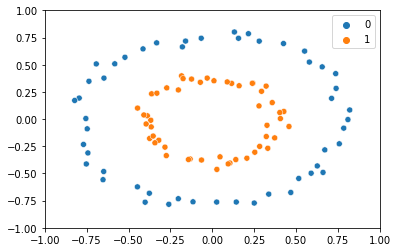

In [21]:
from sklearn.datasets import make_circles
import seaborn as sns
X_circle, y_circle = make_circles(n_samples= 100, noise=0.05, factor=0.5,random_state=1)
X_circle *= 0.8
plot = sns.scatterplot(x= X_circle[:,0], y=X_circle[:,1],hue=y_circle)
plot.set(xlim=(-1,1), ylim=(-1,1))

In [30]:
model=handmade_nn(2)
model.add_dense_layer(4,'tanh')
model.add_dense_layer(3,'tanh')
model.add_dense_layer(1,'sigmoid')

In [31]:
model.fit(X_circle,y_circle,loss='binary_crossentropy',n_epochs=1000,batch_size=16)

initial loss: 0.6943541660953805
final loss: 0.6486756628842517


In [32]:
model.fit(X_circle,y_circle,loss='binary_crossentropy',n_epochs=1000,batch_size=16,optimizer='adam')

initial loss: 0.6486756628842517
final loss: 0.009061494065794722
